In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
from scipy.interpolate import RegularGridInterpolator

from pathlib import Path
from MITRotor import BEM, IEA10MW, IEA15MW, BEMGeometry, AerodynamicProperties, NoTipLoss, PrandtlTipLoss, ConstantInduction, KraghAerodynamics, ClassicalMomentum, UnifiedMomentum, MadsenMomentum, NoTangentialInduction, DefaultTangentialInduction, BEMSolution


In [2]:
# # plt.style.use('/anvil/scratch/x-smata/postprocessing/scripts/figures_layout.mplstyle')
fontsize = 24
plt.rcParams['xtick.labelsize'] = 20 
plt.rcParams['ytick.labelsize'] = 20 

plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

In [3]:
def per_error(A, E):
    error = ((A - E) / E) * 100

    return error

def interp_polars(r,t,R,T,data):
    interpolator = RegularGridInterpolator(
        (r, t), 
        data, 
        bounds_error=False, 
        fill_value=None  # Enables extrapolation
    )

    # Interpolation points
    points_new = np.column_stack((R.ravel(), T.ravel()))

    # Interpolate to new points
    return interpolator(points_new).reshape(R.shape)

In [4]:
casenames = [r's0_v4', r'sn2_v2', r's0_v2',r's2_v2', r'sn4_v0', r'sn2_v0', r's0_v0', r's2_v0', r's4_v0', r'sn2_vn2', r's0_vn2', r's2_vn2', r's0_vn4']
# casenames = [r's0_v0']

# casenames = [r's0_v0']


wrfles_data = []
for count, name in enumerate(casenames):
    wrfles_data.append(dict(np.load('/scratch/09909/smata/wrf_les_sweep/runs/old_clockwise/gad_sweep/'+casenames[count]+'.npz')))


wrf_ind = np.zeros(len(casenames))
mit_ind = np.zeros(len(casenames))

wrf_thr = np.zeros(len(casenames))
mit_thr = np.zeros(len(casenames))

wrf_pow = np.zeros(len(casenames))
mit_pow = np.zeros(len(casenames))

In [5]:
ref = 6

solutions = {}

In [6]:
for count in range(len(casenames)):
    y = (wrfles_data[count]['Y3'] - wrfles_data[count]['rotor_yloc'])/(wrfles_data[count]['diameter']/2)
    z = (wrfles_data[count]['Z3'] - wrfles_data[count]['hub_height'])/(wrfles_data[count]['diameter']/2)

    r     = (y**2 + z**2)**(1/2)
    theta = np.arctan2(y,z)

    ws  = ((np.mean(wrfles_data[count]['ux_n4D'], axis=0)**2 + np.mean(wrfles_data[count]['vx_n4D'], axis=0)**2)**(1/2) / wrfles_data[count]['uinf'])
    wd  = (np.arctan2(np.mean(wrfles_data[count]['vx_n4D'], axis=0), np.mean(wrfles_data[count]['ux_n4D'], axis=0)))

    # ws  = ((np.mean(wrfles_data[count]['ux_0D'], axis=0)**2 + np.mean(wrfles_data[count]['vx_0D'], axis=0)**2)**(1/2) / wrfles_data[count]['uinf'])
    # wd  = (np.arctan2(np.mean(wrfles_data[count]['vx_0D'], axis=0), np.mean(wrfles_data[count]['ux_0D'], axis=0)))

    ct  = np.mean(wrfles_data[count]['ct'],  axis=0)
    cp  = np.mean(wrfles_data[count]['cp'],  axis=0)
    cl  = np.mean(wrfles_data[count]['cl'],  axis=0)
    cd  = np.mean(wrfles_data[count]['cd'],  axis=0)
    aoa = np.mean(wrfles_data[count]['aoa'], axis=0)
    f   = np.mean(wrfles_data[count]['f'],   axis=0)
    fn  = np.mean(wrfles_data[count]['fn'],  axis=0)
    ft  = np.mean(wrfles_data[count]['ft'],  axis=0)
    vd  = np.mean(wrfles_data[count]['v1'],  axis=0)

    Ad = np.pi * (wrfles_data[count]['diameter']/2)**2

    # Mask points where r > R
    mask = r <= 1.5
    r_filtered     = r[mask]
    theta_filtered = theta[mask]
    ws_filtered    = ws[mask]
    wd_filtered    = wd[mask]

    # Interpolate to new polar grid
    r_new = np.linspace(0.0, 0.99999, 60)  # 50 points in r
    theta_new = np.linspace(0, 2 * np.pi, 360)  # 100 points in theta
    Theta_new, R_new = np.meshgrid(theta_new, r_new)

    # Convert new polar grid to Cartesian for interpolation
    X_new = R_new * np.sin(Theta_new)
    Y_new = R_new * np.cos(Theta_new)

    # Interpolate data to the new polar grid
    ws_rt = griddata(
        points=(y[mask], z[mask]),
        values=ws_filtered,
        xi=(X_new, Y_new),
        method='linear'
    )
    # Interpolate data to the new polar grid
    wd_rt = griddata(
        points=(y[mask], z[mask]),
        values=wd_filtered,
        xi=(X_new, Y_new),
        method='linear'
    )

    cl_r = wrfles_data[count]['rOverR']
    # cl_t = np.linspace(0, 2 * np.pi, 158) + np.pi/2
    cl_t = np.linspace(0, 2 * np.pi, 158)

    cl_T, cl_R = np.meshgrid(cl_t, cl_r)

    cl_x = cl_R * np.sin(cl_T)
    cl_y = cl_R * np.cos(cl_T)

    cl_r_new = np.linspace(0.0, 0.99999, 60)
    # cl_t_new = np.linspace(0, 2 * np.pi, 360) + np.pi/2
    cl_t_new = np.linspace(0, 2 * np.pi, 360)

    cl_T_new, cl_R_new = np.meshgrid(cl_t_new, cl_r_new)

    cl_x_new = cl_R_new * np.cos(cl_T_new)
    cl_y_new = cl_R_new * np.sin(cl_T_new)

    # Mask points where r > R
    mask = r <= 1.5
    r_filtered     = r[mask]
    theta_filtered = theta[mask]
    ws_filtered    = ws[mask]
    wd_filtered    = wd[mask]

    # Interpolate to new polar grid
    r_new = np.linspace(0.0, 1.05, 60)  # 50 points in r
    theta_new = np.linspace(0, 2 * np.pi, 360)  # 100 points in theta
    Theta_new, R_new = np.meshgrid(theta_new, r_new)

    # Convert new polar grid to Cartesian for interpolation
    X_new = R_new * np.sin(Theta_new)
    Y_new = R_new * np.cos(Theta_new)

    # Initialize rotor with increased radial resolution.
    rotor = IEA10MW()

    # bem = BEM(rotor=rotor, geometry=BEMGeometry(Nr=60, Ntheta=360), aerodynamic_model=KraghAerodynamics(), tiploss_model=NoTipLoss(), momentum_model=ConstantInduction(), tangential_induction_model=DefaultTangentialInduction())
    bem = BEM(rotor=rotor, geometry=BEMGeometry(Nr=60, Ntheta=360), aerodynamic_model=KraghAerodynamics(), tiploss_model=NoTipLoss(), momentum_model=ClassicalMomentum(), tangential_induction_model=NoTangentialInduction())
    # bem = BEM(rotor=rotor, geometry=BEMGeometry(Nr=60, Ntheta=360), aerodynamic_model=KraghAerodynamics(), tiploss_model=NoTipLoss(), momentum_model=MadsenMomentum(), tangential_induction_model=NoTangentialInduction())


    pitch, tsr, yaw = np.deg2rad(0), 10.634, np.deg2rad(0.0)
    sol = bem(pitch, tsr, yaw, U=ws_rt, wdir=wd_rt)

    solutions[count] = sol

    aoa_rt  = ws_rt * wrfles_data[count]['uinf'] * np.cos(wd_rt)

    wrf_ind[count] = 1/Ad * np.trapezoid(np.trapezoid((1- aoa_rt.T/wrfles_data[count]['uinf']) * cl_R_new[:,0] * (wrfles_data[count]['diameter']/2), cl_R_new[:,0] * (wrfles_data[count]['diameter']/2)), cl_T_new[0,:])
    # mit_ind[count] = 1/Ad * np.trapezoid(np.trapezoid((1- (sol.U('sector') * np.cos(sol.wdir('sector'))).T) * sol.geom.mu * (wrfles_data[count]['diameter']/2), sol.geom.mu * (wrfles_data[count]['diameter']/2)), sol.geom.theta)
    mit_ind[count] = 1/Ad * np.trapezoid(np.trapezoid(((sol.a('sector')).T) * sol.geom.mu * (wrfles_data[count]['diameter']/2), sol.geom.mu * (wrfles_data[count]['diameter']/2)), sol.geom.theta)

    # wrf_thr[count] = wrfles_data[count]['thrust'].mean()
    # mit_thr[count] = 1/Ad * np.trapezoid(np.trapezoid(((sol.Ct('sector')).T) * sol.geom.mu * (wrfles_data[count]['diameter']/2), sol.geom.mu * (wrfles_data[count]['diameter']/2)), sol.geom.theta)

    wrf_thr[count] = wrfles_data[count]['thrust'].mean()
    # mit_thr = 1/Ad * np.trapezoid(np.trapezoid(((sol.Ct('sector')).T) * sol.geom.mu * (wrfles_data[count]['diameter']/2), sol.geom.mu * (wrfles_data[count]['diameter']/2)), sol.geom.theta)
    mit_dT = (0.5 * 3 * 1.225 * rotor.chord_func(sol.geom.mu) * ((sol.W('sector') * 7)**2 * sol.Cax('sector')).T).T
    mit_thr[count] = np.trapezoid(np.trapezoid(mit_dT, sol.geom.theta), sol.geom.mu * rotor.R) / (2 * np.pi)

    wrf_pow[count] = wrfles_data[count]['power_aero'].mean()
    mit_dQ = (0.5 * 3 * 1.225 * rotor.chord_func(sol.geom.mu) * ((sol.W('sector') * 7)**2 * sol.Ctan('sector')).T) * sol.geom.mu * rotor.R
    mit_dP = mit_dQ * sol.tsr * 7 / rotor.R
    # mit_pow[count] = 1/Ad * np.trapezoid(np.trapezoid(((sol.Cp('sector')).T) * sol.geom.mu * (wrfles_data[count]['diameter']/2), sol.geom.mu * (wrfles_data[count]['diameter']/2)), sol.geom.theta)
    mit_pow[count] = np.trapezoid(np.trapezoid(mit_dP.T, sol.geom.theta), sol.geom.mu * rotor.R) / (2 * np.pi)

In [7]:
solutions[ref].niter

19

In [10]:
solutions[0].niter

27

In [ ]:
solutions[0].

/tmp/ipykernel_196613/1424701403.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  pow_levels = plt.cm.get_cmap('seismic', n_levels)  # Extract 13 colors from 'viridis'
/tmp/ipykernel_196613/1424701403.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  thr_levels = plt.cm.get_cmap('PiYG', n_levels)  # Extract 13 colors from 'viridis'
/tmp/ipykernel_196613/1424701403.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ind_levels = plt.cm.get_cmap('Spectral',

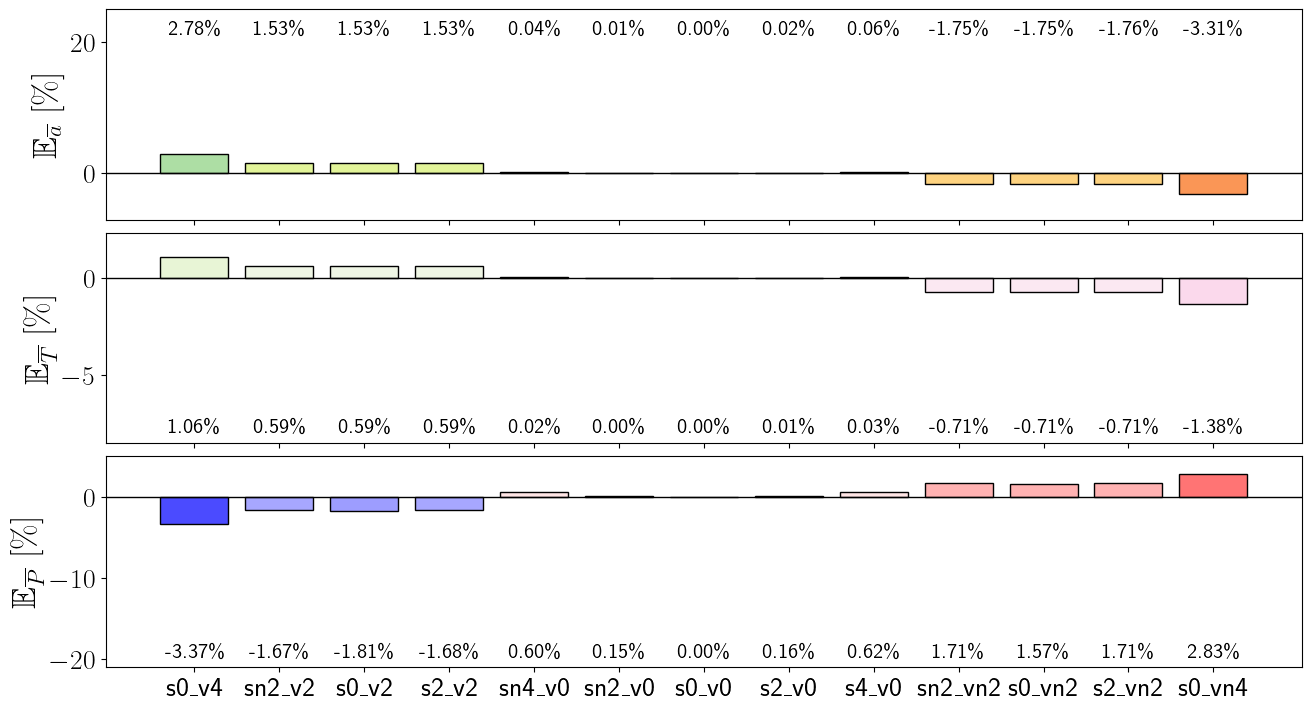

In [41]:
induction = per_error(mit_ind, mit_ind[ref])
thrust    = per_error(mit_thr, mit_thr[ref])
power     = per_error(mit_pow, mit_pow[ref])

casenames = [r's0_v4', r'sn2_v2', r's0_v2',r's2_v2', r'sn4_v0', r'sn2_v0', r's0_v0', r's2_v0', r's4_v0', r'sn2_vn2', r's0_vn2', r's2_vn2', r's0_vn4']

n_levels = 100

pow_levels = plt.cm.get_cmap('seismic', n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=-10, vmax=10)  # Normalize power to [0, 1]
pow_cmap = [pow_levels(int(norm(p) * (n_levels - 1))) for p in power]  # Map power to discrete colors

thr_levels = plt.cm.get_cmap('PiYG', n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=-6, vmax=6)  # Normalize power to [0, 1]
thr_cmap = [thr_levels(int(norm(t) * (n_levels - 1))) for t in thrust]  # Map power to discrete colors

ind_levels = plt.cm.get_cmap('Spectral', n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=-7, vmax=7)  # Normalize power to [0, 1]
ind_cmap = [ind_levels(int(norm(a) * (n_levels - 1))) for a in induction]  # Map power to discrete colors


width = 0.75
alpha = 1.0

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(13, 7), sharex=True, constrained_layout = True)
ax[0].axhline(0, color='black', linestyle='solid', linewidth=1)
ax[1].axhline(0, color='black', linestyle='solid', linewidth=1)
ax[2].axhline(0, color='black', linestyle='solid', linewidth=1)
# ax[3].axhline(0, color='black', linestyle='solid', linewidth=1)

ind = np.arange(len(casenames))

for count in range(len(casenames)):

    # induction
    ax[0].bar(ind[count], induction[count], color=ind_cmap[count], edgecolor='black', alpha=alpha)
    ax[0].set_ylabel(r'$\mathrm{\mathbb{E}}_{\overline{a}}~[\%]$', fontsize=fontsize)
    ax[0].text(ind[count], 21, f'{induction[count]:0.2f}\%', ha='center', fontsize=15)
    # ax[0].set_ylim([-4.5,18])
    ax[0].set_ylim([-7.2,25])

    # thrust
    ax[1].bar(ind[count], thrust[count], color=thr_cmap[count], edgecolor='black', alpha=alpha)
    ax[1].set_ylabel(r'$\mathrm{\mathbb{E}}_{\overline{T}}~[\%]$', fontsize=fontsize)
    # ax[1].text(ind[count], -4.75, f'{thrust[count]}\%', ha='center', fontsize=15)
    # ax[1].set_ylim([-5,1.5])
    ax[1].text(ind[count], -8, f'{thrust[count]:0.2f}\%', ha='center', fontsize=15)
    ax[1].set_ylim([-8.5,2.3])

    # # torque
    # ax[2].bar(ind[count], wrfles_rel_diff_torque, color=colors[count], edgecolor='black', alpha=alpha)
    # ax[2].set_ylabel(r'$\mathrm{\mathbb{E}}_{\overline{Q}}~[\%]$', fontsize=fontsize)
    # ax[2].text(ind[count], -8, f'{wrfles_rel_diff_torque[0]}\%', ha='center', fontsize=15)

    # power
    ax[2].bar(ind[count], power[count], color=pow_cmap[count], edgecolor='black', alpha=alpha)
    ax[2].set_xticks(ind)
    ax[2].set_xticklabels(casenames)
    ax[2].set_ylabel(r'$\mathrm{\mathbb{E}}_{\overline{P}}~[\%]$', fontsize=fontsize)
    ax[2].text(ind[count], -20, f'{power[count]:0.2f}\%', ha='center', fontsize=15)
    # ax[2].set_ylim([-14,4])
    ax[2].set_ylim([-21,5])

plt.savefig("/scratch/09909/smata/wrf_les_sweep/runs/old_clockwise/gad_sweep/figs/mit_no_ind_closure.png", bbox_inches="tight", dpi=800)
plt.show()

/tmp/ipykernel_2353449/4234351171.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  pow_levels = plt.cm.get_cmap('seismic', n_levels)  # Extract 13 colors from 'viridis'
/tmp/ipykernel_2353449/4234351171.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  thr_levels = plt.cm.get_cmap('PiYG', n_levels)  # Extract 13 colors from 'viridis'
/tmp/ipykernel_2353449/4234351171.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ind_levels = plt.cm.get_cmap('Spectra

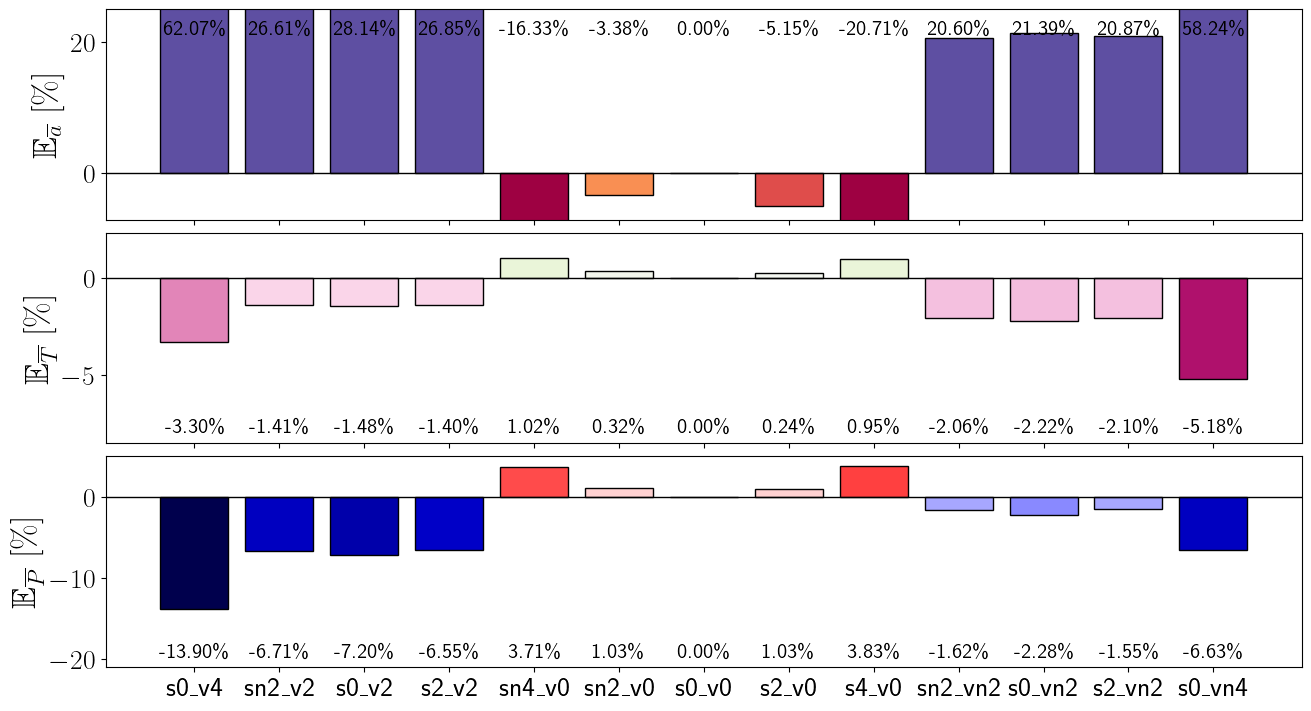

In [8]:
induction = per_error(wrf_ind, wrf_ind[ref])
thrust    = per_error(wrf_thr, wrf_thr[ref])
power     = per_error(wrf_pow, wrf_pow[ref])

casenames = [r's0_v4', r'sn2_v2', r's0_v2',r's2_v2', r'sn4_v0', r'sn2_v0', r's0_v0', r's2_v0', r's4_v0', r'sn2_vn2', r's0_vn2', r's2_vn2', r's0_vn4']

n_levels = 100

pow_levels = plt.cm.get_cmap('seismic', n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=-10, vmax=10)  # Normalize power to [0, 1]
pow_cmap = [pow_levels(int(norm(p) * (n_levels - 1))) for p in power]  # Map power to discrete colors

thr_levels = plt.cm.get_cmap('PiYG', n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=-6, vmax=6)  # Normalize power to [0, 1]
thr_cmap = [thr_levels(int(norm(t) * (n_levels - 1))) for t in thrust]  # Map power to discrete colors

ind_levels = plt.cm.get_cmap('Spectral', n_levels)  # Extract 13 colors from 'viridis'
norm = mcolors.Normalize(vmin=-7, vmax=7)  # Normalize power to [0, 1]
ind_cmap = [ind_levels(int(norm(a) * (n_levels - 1))) for a in induction]  # Map power to discrete colors


width = 0.75
alpha = 1.0

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(13, 7), sharex=True, constrained_layout = True)
ax[0].axhline(0, color='black', linestyle='solid', linewidth=1)
ax[1].axhline(0, color='black', linestyle='solid', linewidth=1)
ax[2].axhline(0, color='black', linestyle='solid', linewidth=1)
# ax[3].axhline(0, color='black', linestyle='solid', linewidth=1)

ind = np.arange(len(casenames))

for count in range(len(casenames)):

    # induction
    ax[0].bar(ind[count], induction[count], color=ind_cmap[count], edgecolor='black', alpha=alpha)
    ax[0].set_ylabel(r'$\mathrm{\mathbb{E}}_{\overline{a}}~[\%]$', fontsize=fontsize)
    ax[0].text(ind[count], 21, f'{induction[count]:0.2f}\%', ha='center', fontsize=15)
    # ax[0].set_ylim([-4.5,18])
    ax[0].set_ylim([-7.2,25])

    # thrust
    ax[1].bar(ind[count], thrust[count], color=thr_cmap[count], edgecolor='black', alpha=alpha)
    ax[1].set_ylabel(r'$\mathrm{\mathbb{E}}_{\overline{T}}~[\%]$', fontsize=fontsize)
    # ax[1].text(ind[count], -4.75, f'{thrust[count]}\%', ha='center', fontsize=15)
    # ax[1].set_ylim([-5,1.5])
    ax[1].text(ind[count], -8, f'{thrust[count]:0.2f}\%', ha='center', fontsize=15)
    ax[1].set_ylim([-8.5,2.3])

    # # torque
    # ax[2].bar(ind[count], wrfles_rel_diff_torque, color=colors[count], edgecolor='black', alpha=alpha)
    # ax[2].set_ylabel(r'$\mathrm{\mathbb{E}}_{\overline{Q}}~[\%]$', fontsize=fontsize)
    # ax[2].text(ind[count], -8, f'{wrfles_rel_diff_torque[0]}\%', ha='center', fontsize=15)

    # power
    ax[2].bar(ind[count], power[count], color=pow_cmap[count], edgecolor='black', alpha=alpha)
    ax[2].set_xticks(ind)
    ax[2].set_xticklabels(casenames)
    ax[2].set_ylabel(r'$\mathrm{\mathbb{E}}_{\overline{P}}~[\%]$', fontsize=fontsize)
    ax[2].text(ind[count], -20, f'{power[count]:0.2f}\%', ha='center', fontsize=15)
    # ax[2].set_ylim([-14,4])
    ax[2].set_ylim([-21,5])

plt.savefig("/scratch/09909/smata/wrf_les_sweep/runs/old_clockwise/gad_sweep/figs/wrf.png", bbox_inches="tight", dpi=800)
plt.show()

In [46]:
solutions[12].U('sector')

array([[0.99158279, 0.99158279, 0.99158279, ..., 0.99158279, 0.99158279,
        0.99158279],
       [0.9916303 , 0.99163031, 0.99163031, ..., 0.99163022, 0.99163027,
        0.9916303 ],
       [0.99178475, 0.99178469, 0.99178443, ..., 0.99178426, 0.99178461,
        0.99178475],
       ...,
       [1.15057566, 1.15053705, 1.15042166, ..., 1.15042193, 1.15053751,
        1.15057566],
       [1.15498561, 1.1549462 , 1.15482839, ..., 1.15482906, 1.15494693,
        1.15498561],
       [1.15939644, 1.15935609, 1.15923604, ..., 1.15923725, 1.15935717,
        1.15939644]], shape=(60, 360))

/tmp/ipykernel_2353449/3290684186.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, current, cmap='seismic',vmin=6,vmax=8)


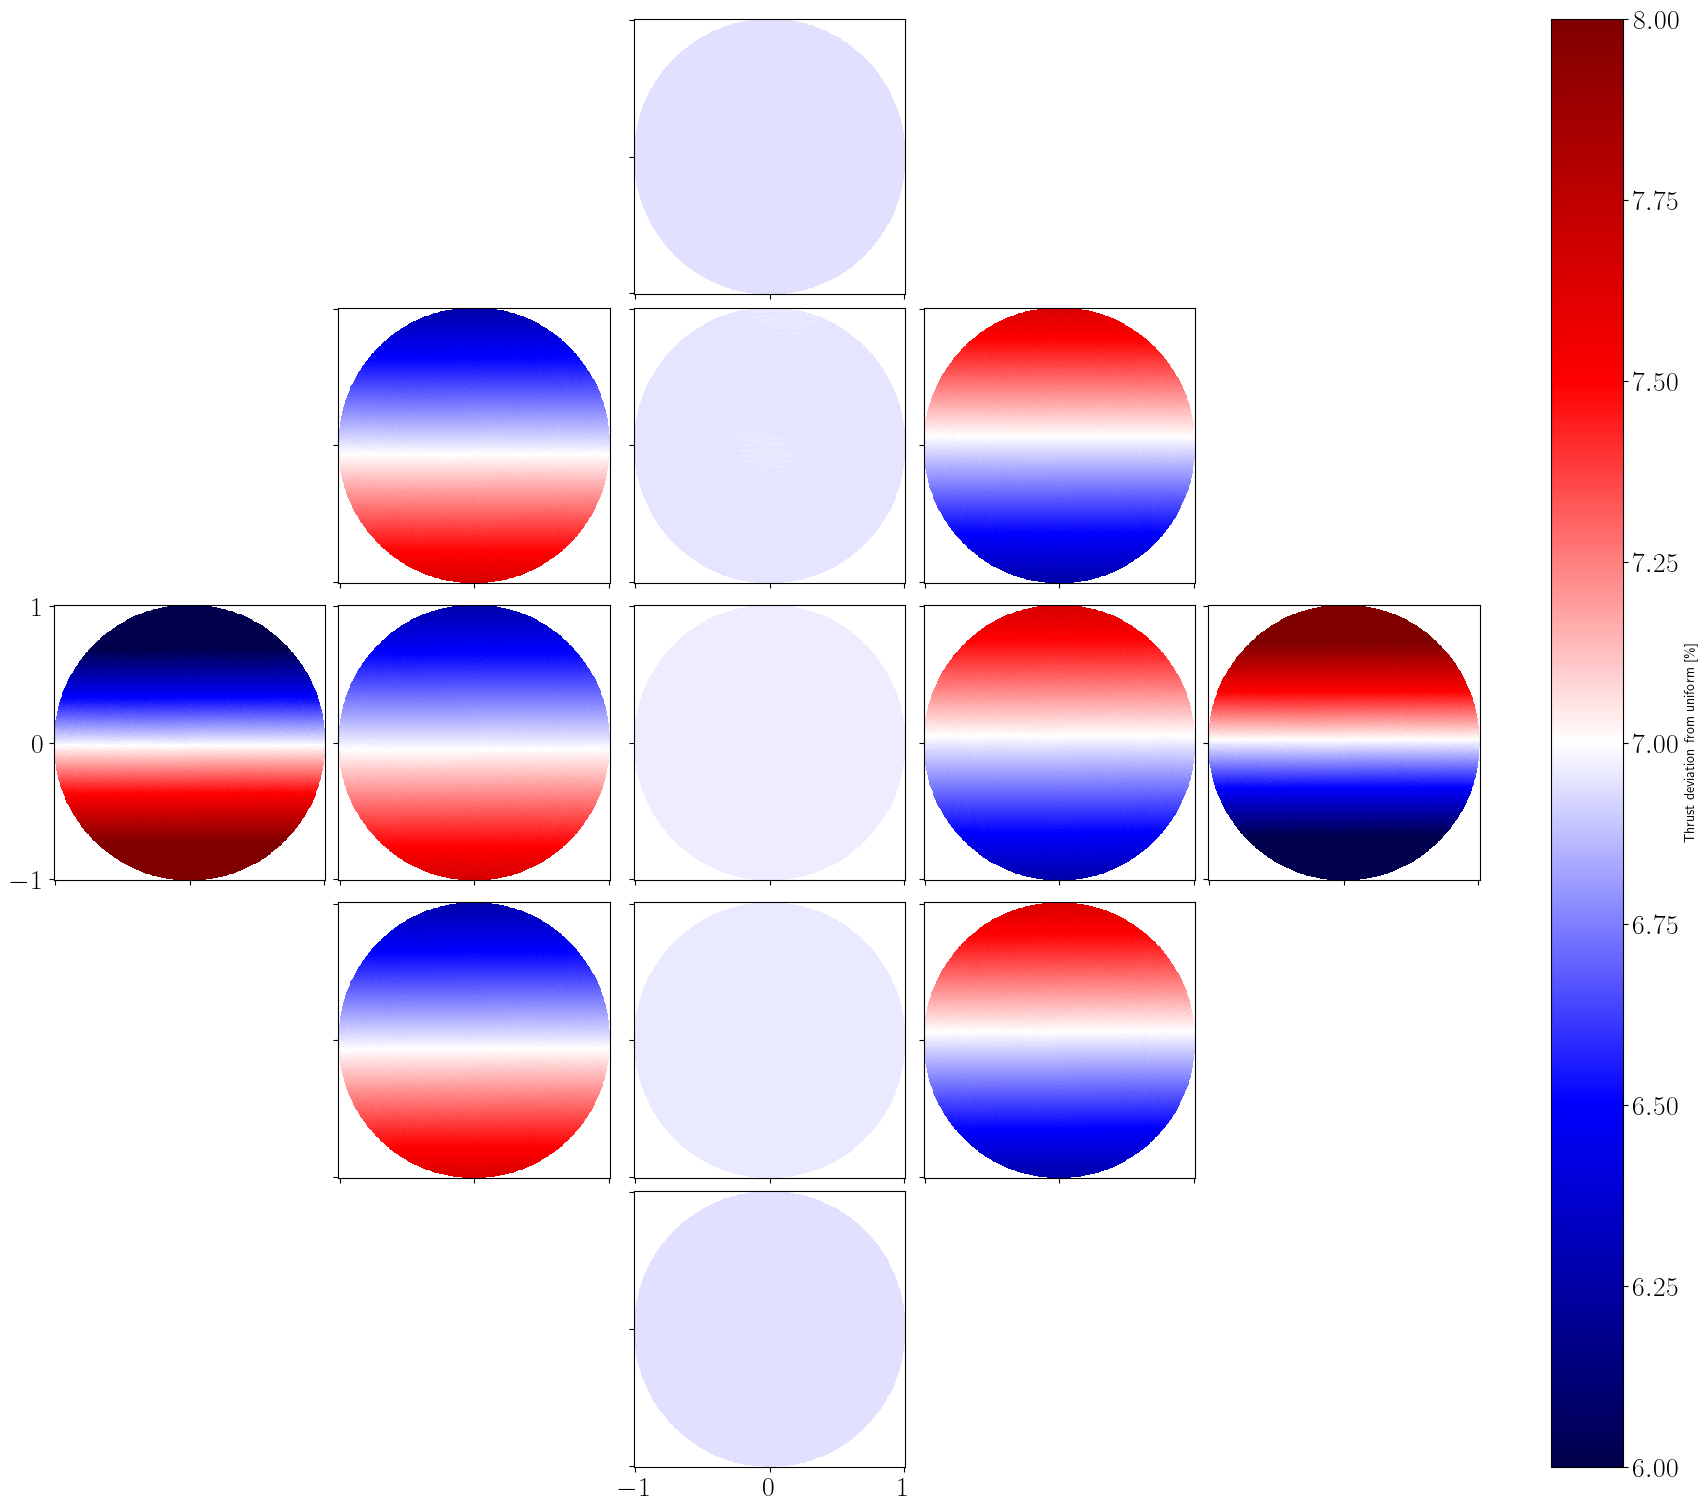

In [ ]:
xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]


fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(17, 15), constrained_layout=True,sharex=True, sharey=True)
    

for i in range(len(xs)):
    current = (solutions[i].U('sector') * 7) * np.cos(solutions[i].wdir('sector'))
    mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, current, cmap='seismic',vmin=6,vmax=8)
    
    # ax[xs[i],ys[i]].invert_yaxis()

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
ax[4,4].axis('off')

# Add a single colorbar on the right-hand side
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('Thrust deviation from uniform [\%]')

/tmp/ipykernel_196613/4233399215.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='PiYG',vmin=-10,vmax=10)
/tmp/ipykernel_196613/4233399215.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='PiYG',vmin=-10,vmax=10)
/tmp/ipykernel_196613/4233399215.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasi

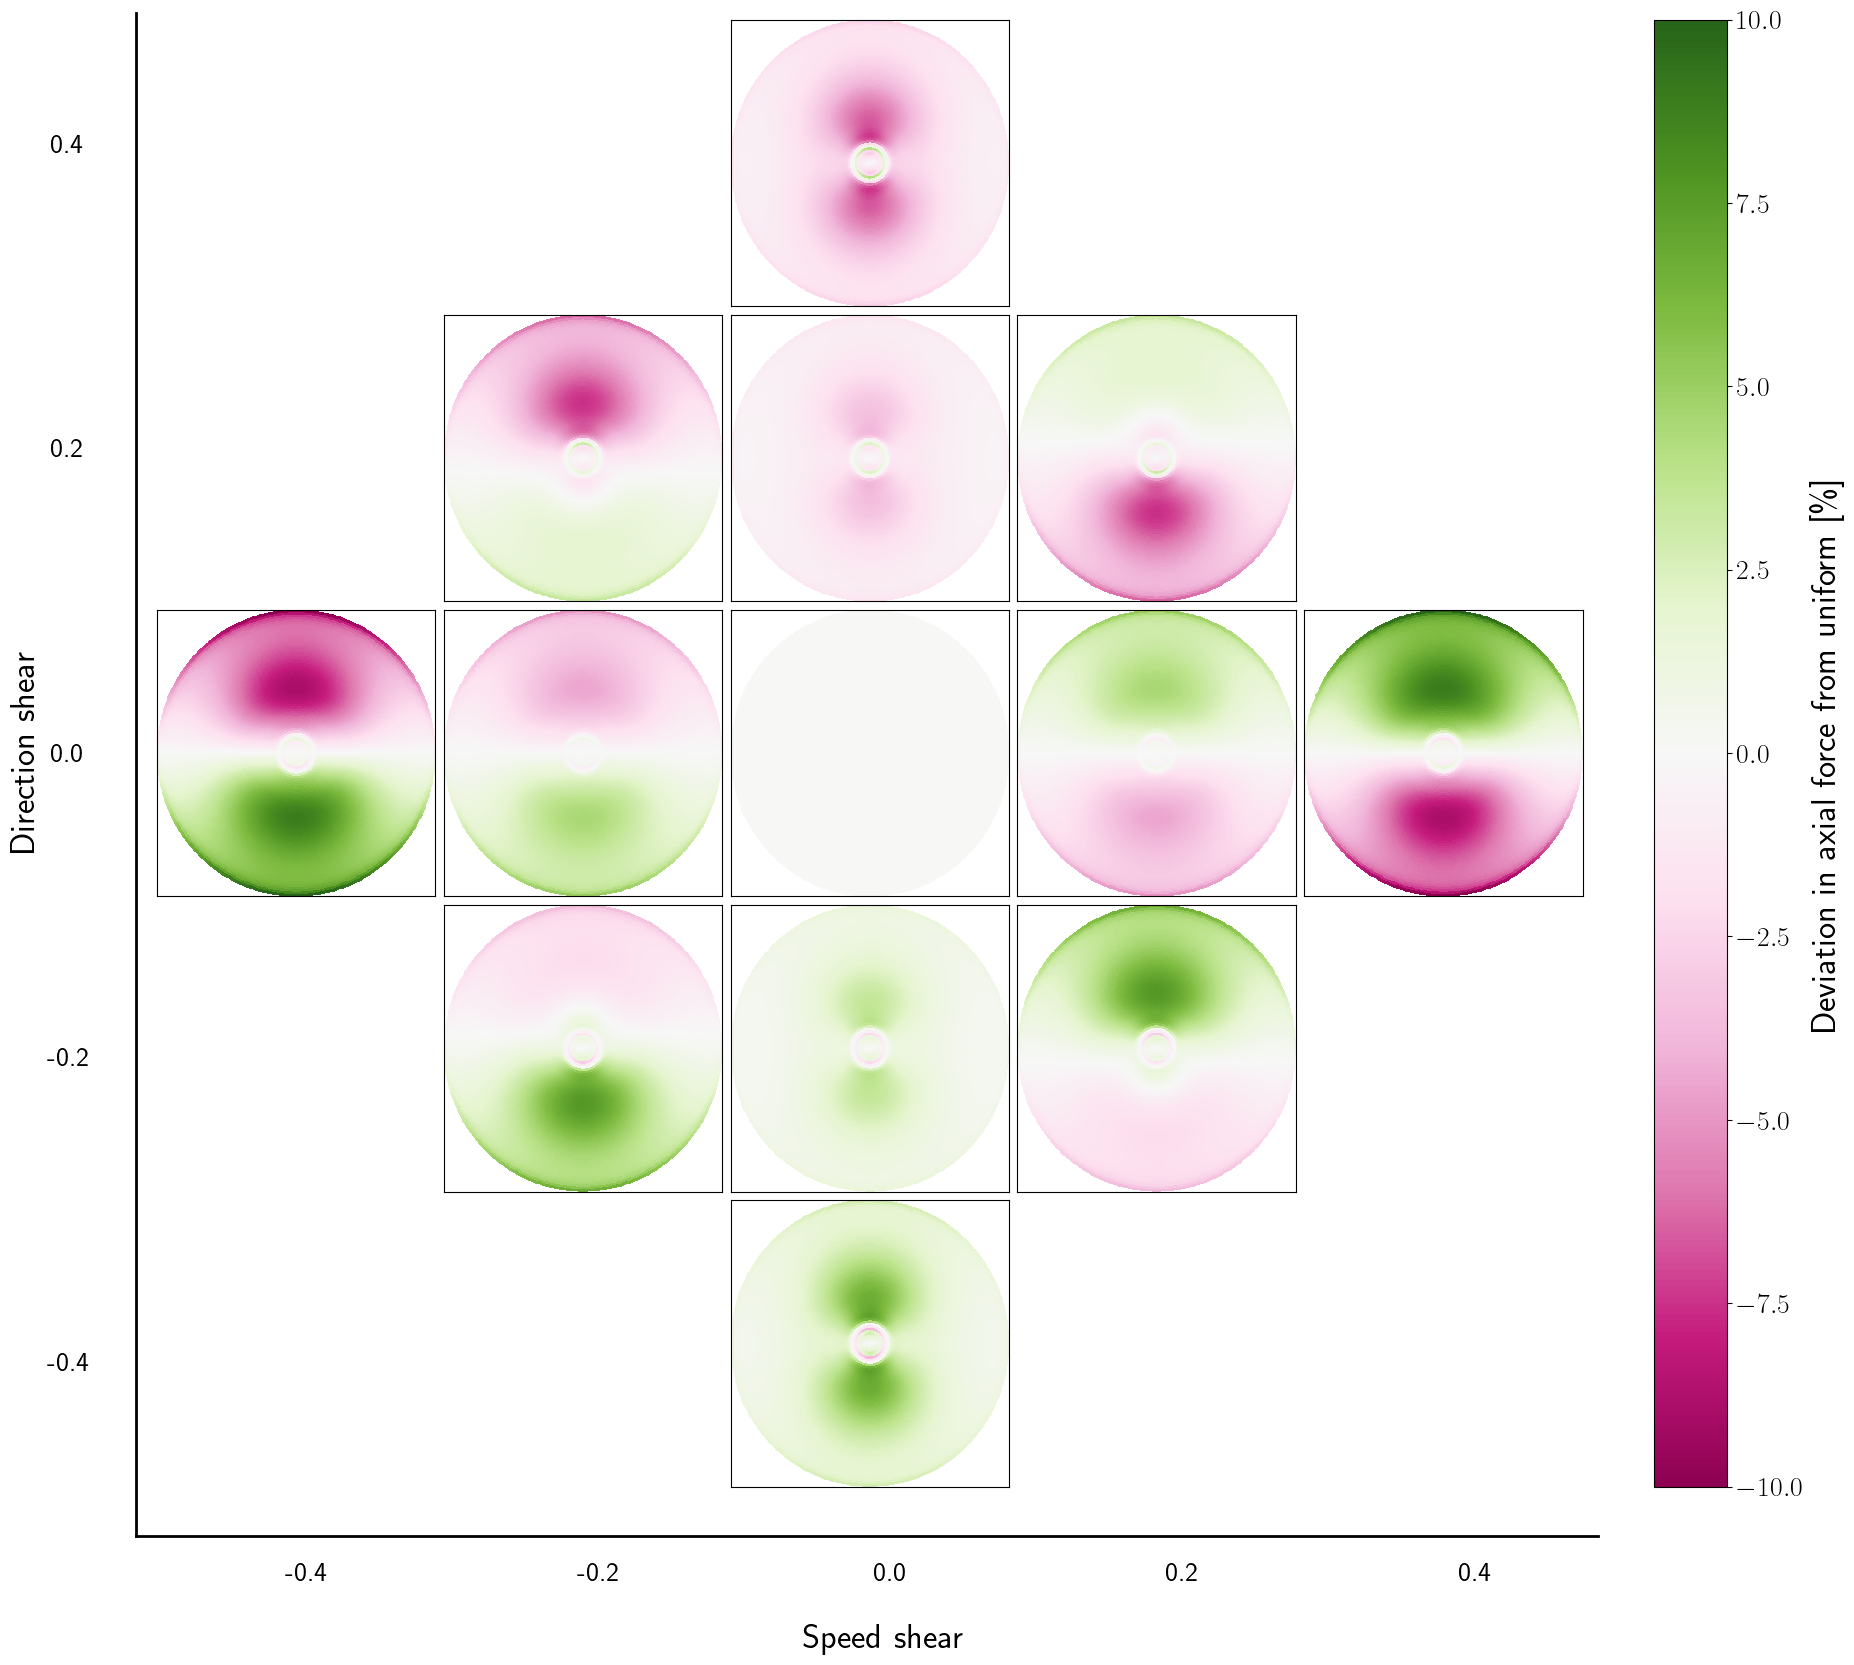

In [45]:
# AXIAL FORCE DEVIATION

xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(17, 15), constrained_layout=True,sharex=True, sharey=True)
    
ref_case = solutions[ref].Cax('sector')

for i in range(len(xs)):
    current = solutions[i].Cax('sector')
    mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='PiYG',vmin=-10,vmax=10)
    # ax[xs[i],ys[i]].invert_yaxis()
    ax[xs[i],ys[i]].set_xticklabels([])
    ax[xs[i],ys[i]].set_yticklabels([])
    ax[xs[i],ys[i]].set_xticks([])
    ax[xs[i],ys[i]].set_yticks([])

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
ax[4,4].axis('off')

# Add a single colorbar on the right-hand side
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('Deviation in axial force from uniform [\%]',fontsize=25)




# Add the number line below the subplots
line_y = -0.02  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.01, 0.85  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.1  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.43, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)


line_x = -0.01  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.02, 0.995  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.11  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.03,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.44, 'Direction shear', ha='center', fontsize=25,rotation=90)

plt.show()

/tmp/ipykernel_196613/2119760623.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='PiYG',vmin=-10,vmax=10)
/tmp/ipykernel_196613/2119760623.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='PiYG',vmin=-10,vmax=10)
/tmp/ipykernel_196613/2119760623.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasi

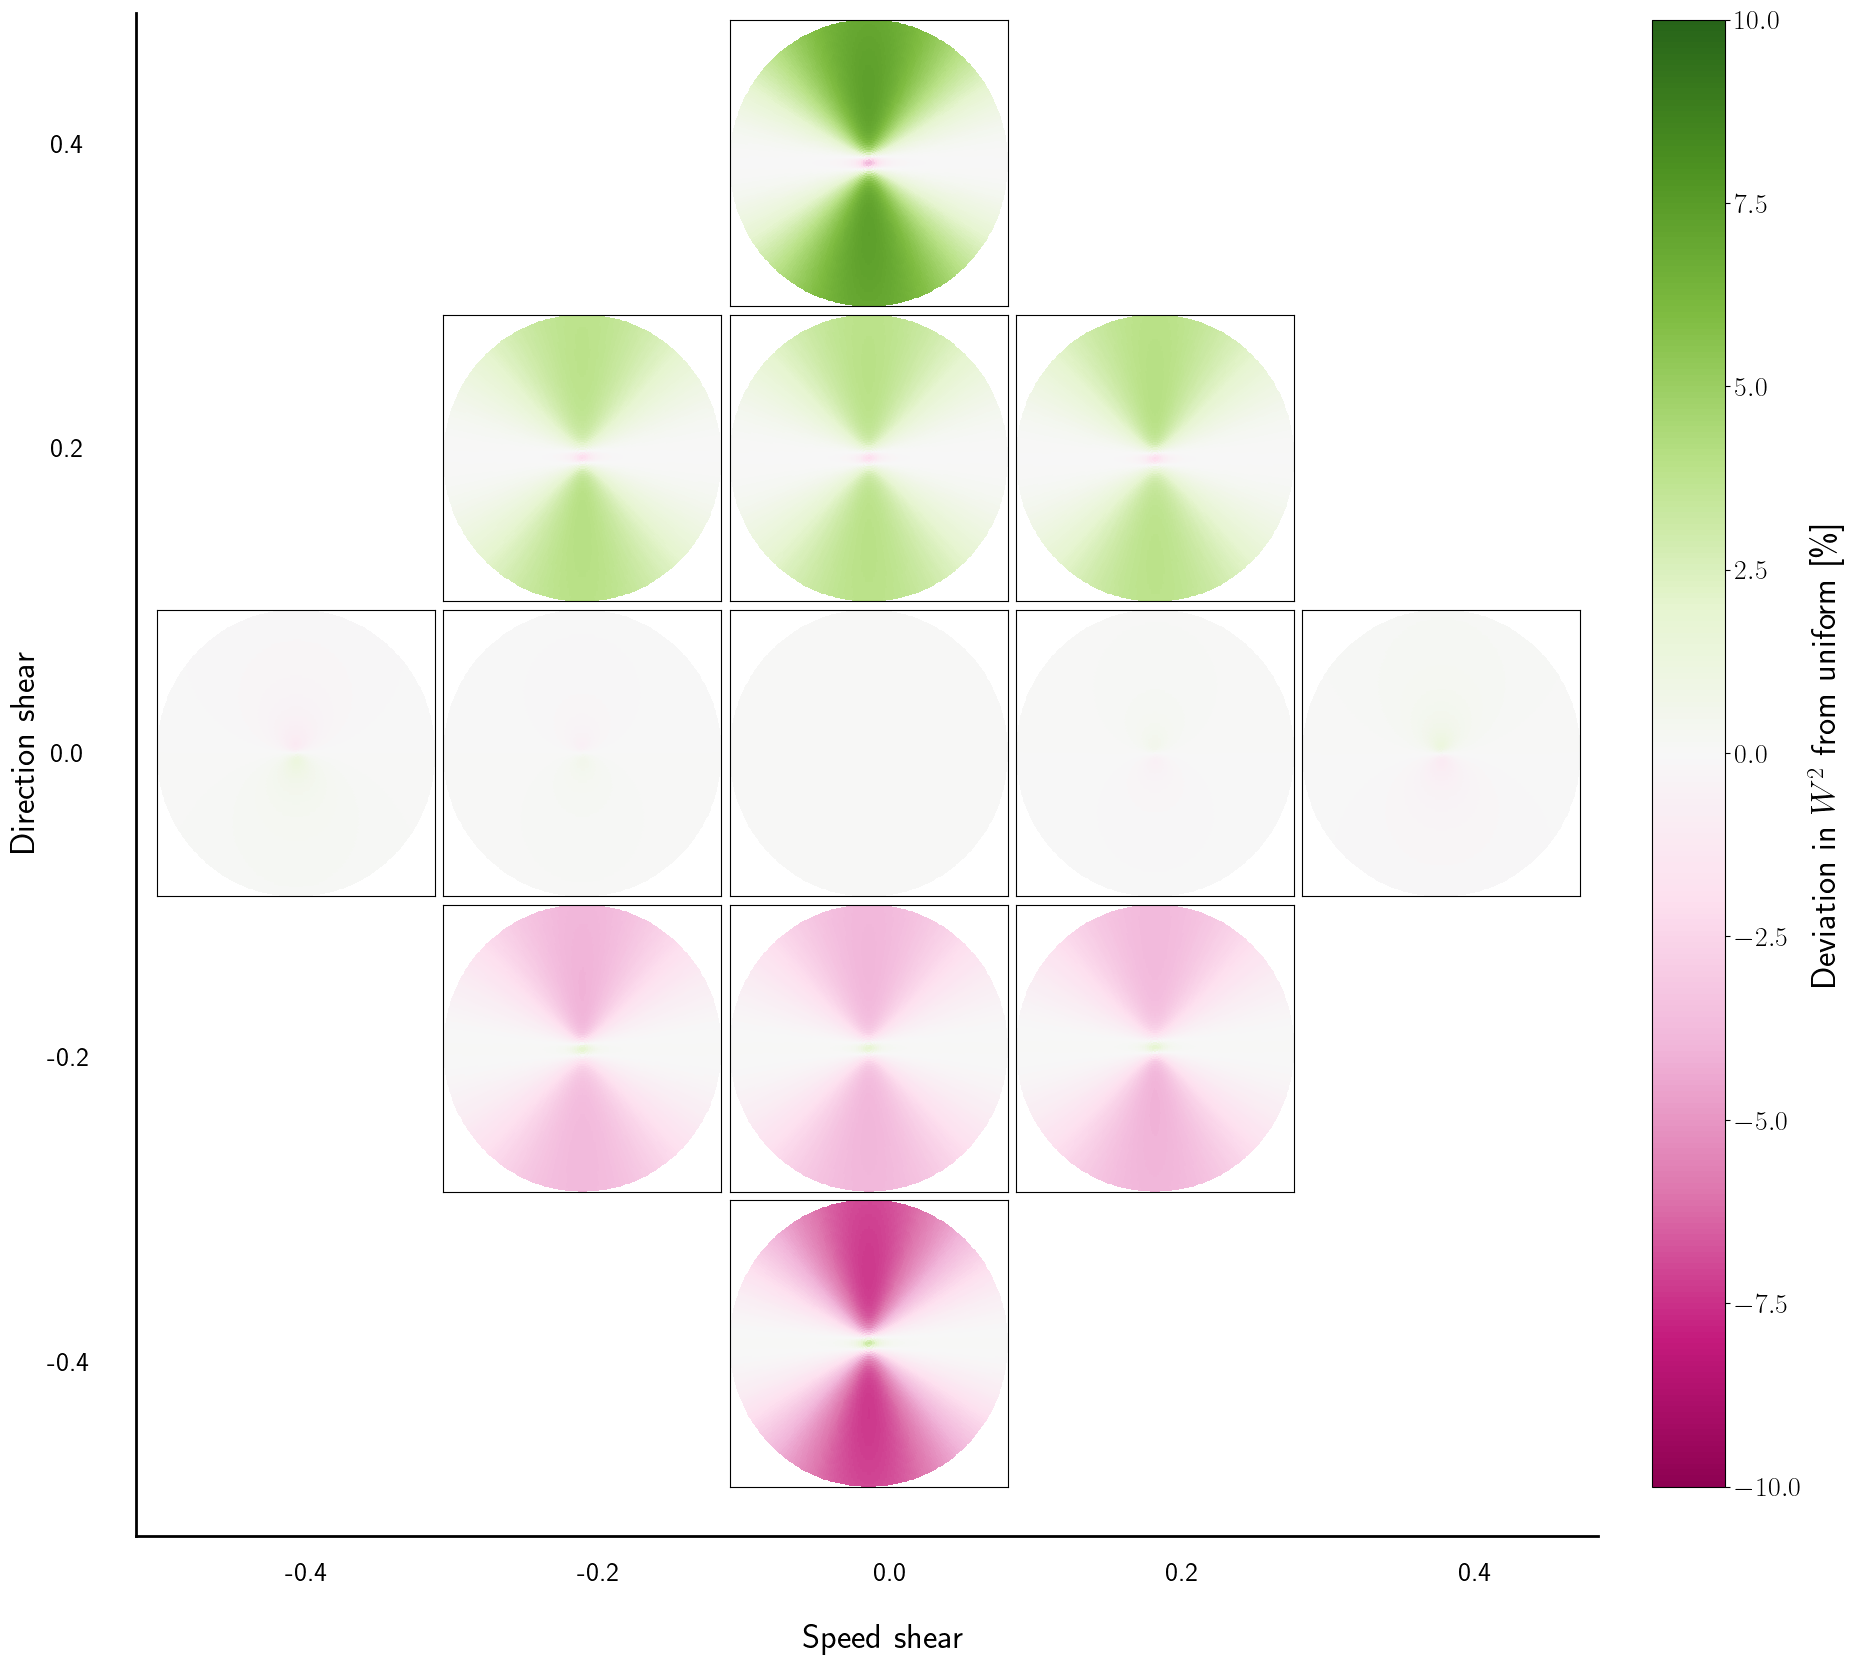

In [46]:
# RELATIVE VELOCITY DEVIATION

xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(17, 15), constrained_layout=True,sharex=True, sharey=True)
    
ref_case = solutions[ref].W('sector')**2

for i in range(len(xs)):
    current = solutions[i].W('sector')**2
    mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='PiYG',vmin=-10,vmax=10)
    # mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-30,vmax=30)
    # ax[xs[i],ys[i]].invert_yaxis()
    ax[xs[i],ys[i]].set_xticklabels([])
    ax[xs[i],ys[i]].set_yticklabels([])
    ax[xs[i],ys[i]].set_xticks([])
    ax[xs[i],ys[i]].set_yticks([])

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
ax[4,4].axis('off')

# Add a single colorbar on the right-hand side
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('Deviation in $W^2$ from uniform [\%]',fontsize=25)




# Add the number line below the subplots
line_y = -0.02  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.01, 0.85  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.1  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.43, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)


line_x = -0.01  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.02, 0.995  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.11  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.03,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.44, 'Direction shear', ha='center', fontsize=25,rotation=90)

plt.show()

/tmp/ipykernel_196613/3328516815.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='PiYG', vmin = -10, vmax = 10)
/tmp/ipykernel_196613/3328516815.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='PiYG', vmin = -10, vmax = 10)
/tmp/ipykernel_196613/3328516815.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing

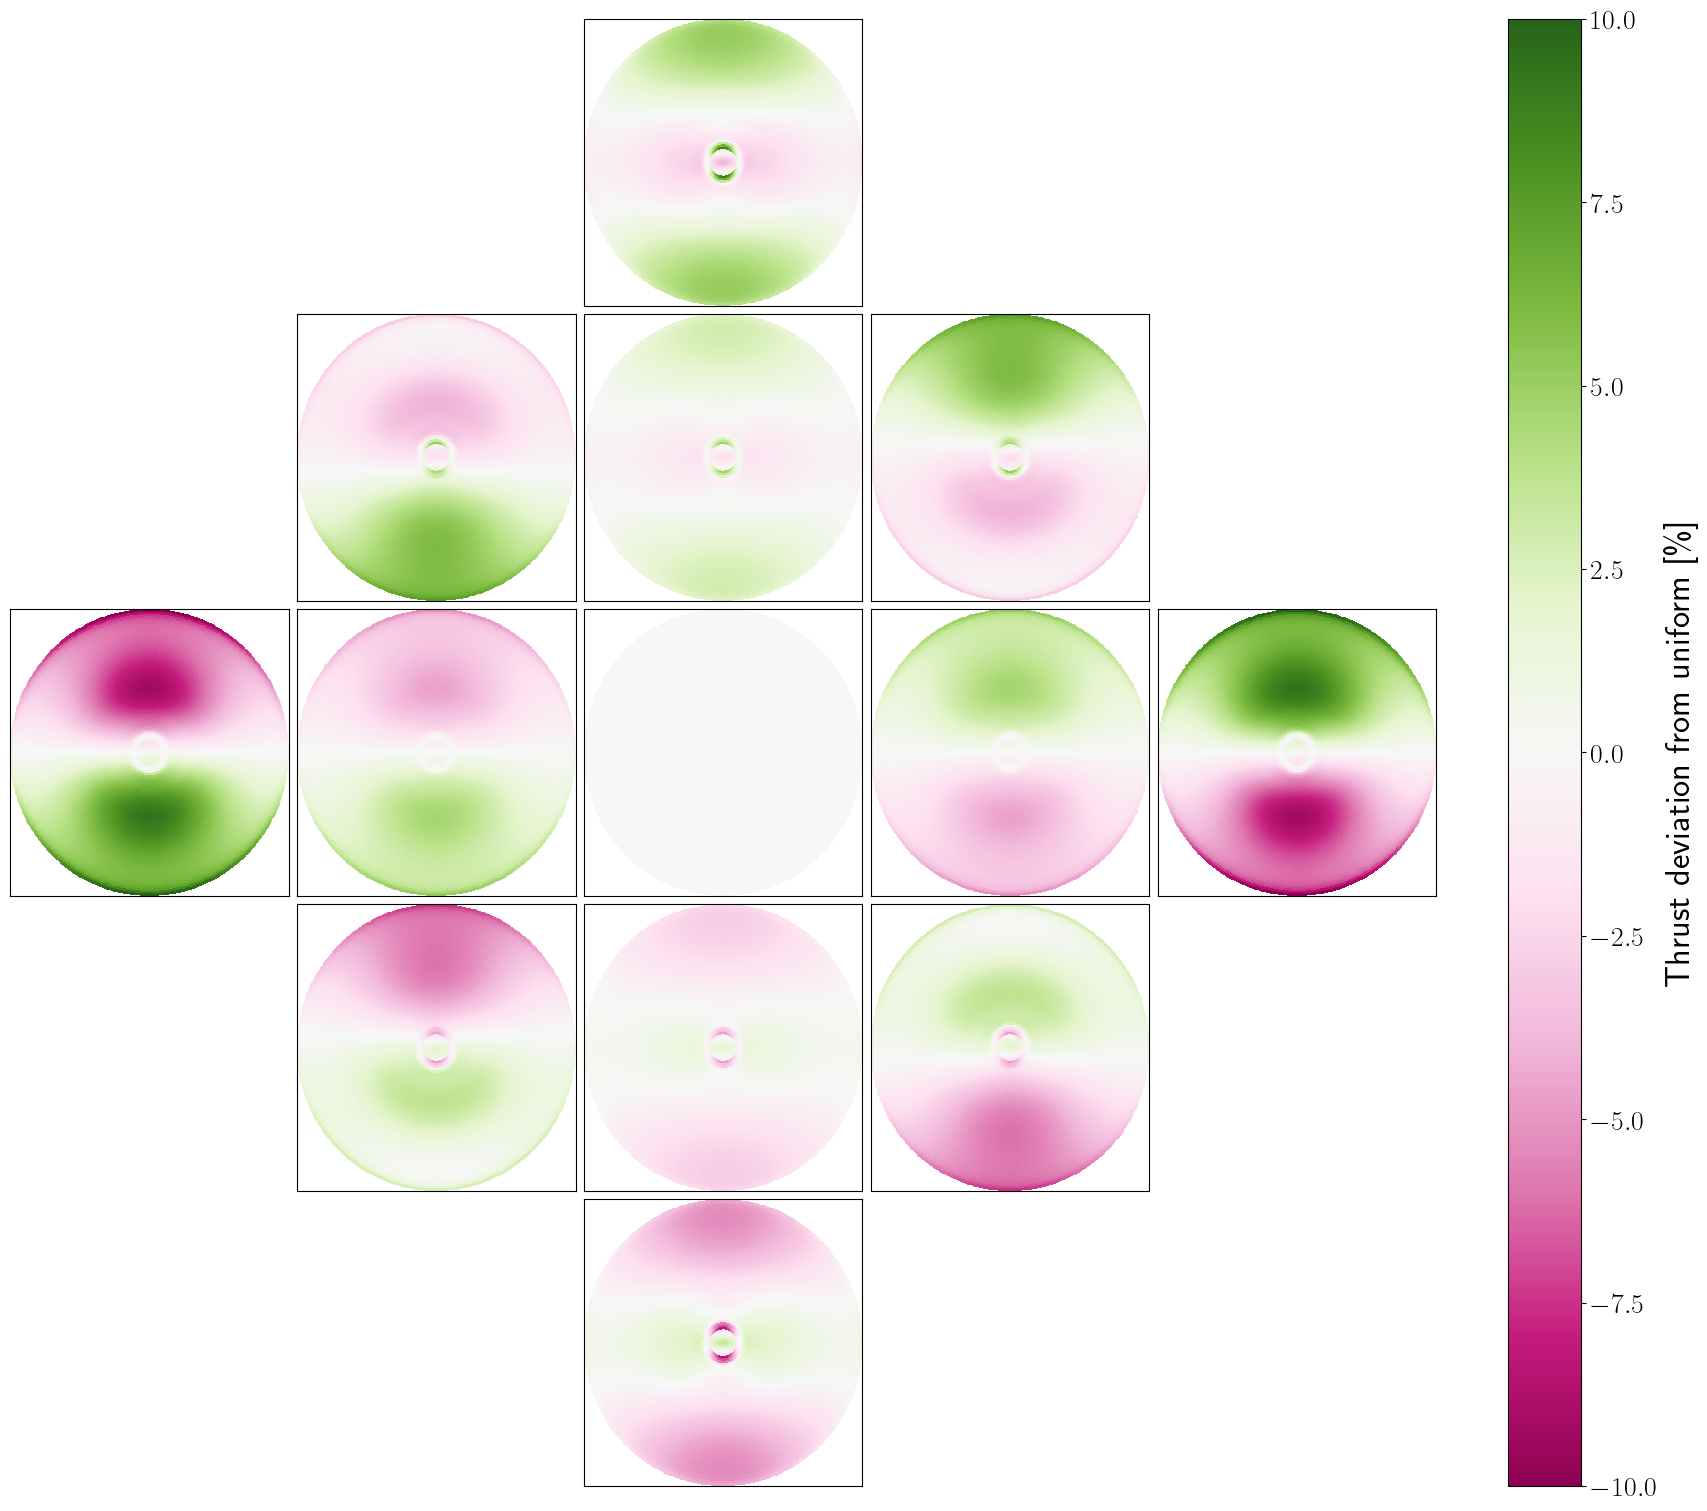

In [47]:

# THRUST DEVIATION

xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]


fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(17, 15), constrained_layout=True,sharex=True, sharey=True)
    
ref_case = (0.5 * 3 * 1.225 * rotor.chord_func(solutions[ref].geom.mu) * ((solutions[ref].W('sector') * 7)**2 * solutions[ref].Cax('sector')).T).T

for i in range(len(xs)):
    current = (0.5 * 3 * 1.225 * rotor.chord_func(solutions[i].geom.mu) * ((solutions[i].W('sector') * 7)**2 * solutions[i].Cax('sector')).T).T
    mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='PiYG', vmin = -10, vmax = 10)
    # ax[xs[i],ys[i]].invert_yaxis()
    ax[xs[i],ys[i]].set_xticklabels([])
    ax[xs[i],ys[i]].set_yticklabels([])
    ax[xs[i],ys[i]].set_xticks([])
    ax[xs[i],ys[i]].set_yticks([])

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
ax[4,4].axis('off')

# Add a single colorbar on the right-hand side
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('Thrust deviation from uniform [\%]',fontsize=25)

/tmp/ipykernel_196613/3106075856.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-30,vmax=30)
/tmp/ipykernel_196613/3106075856.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-30,vmax=30)
/tmp/ipykernel_196613/3106075856.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or de

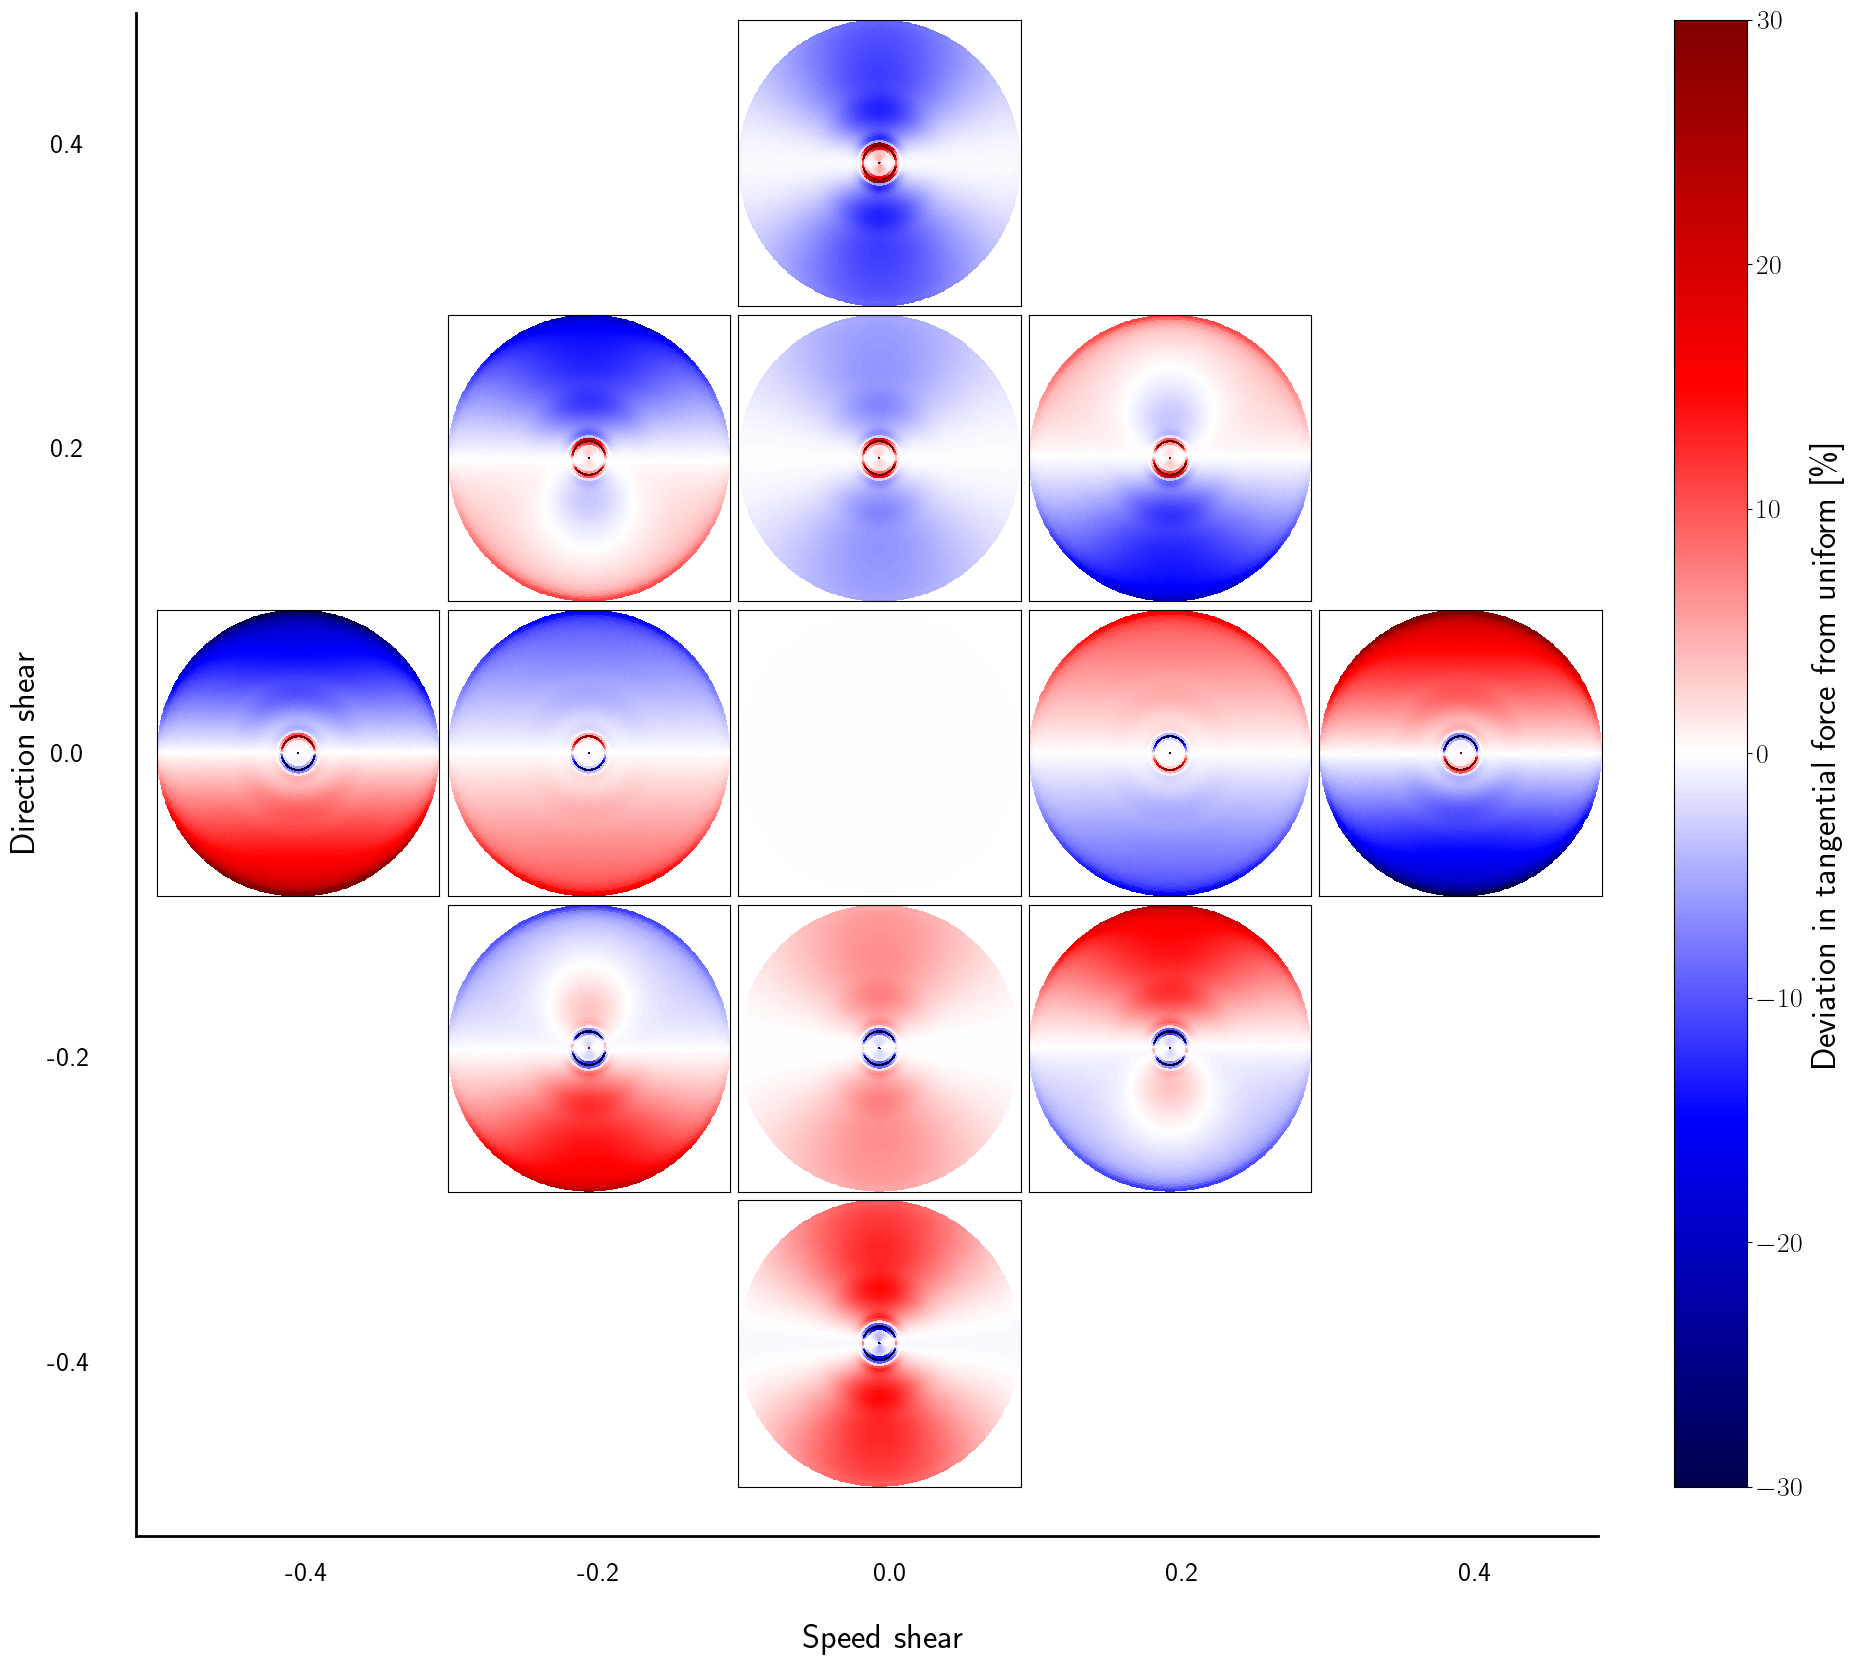

In [36]:
# TANGENTIAL FORCE DEVIATION

xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(17, 15), constrained_layout=True,sharex=True, sharey=True)
    
ref_case = solutions[ref].Ctan('sector')

for i in range(len(xs)):
    current = solutions[i].Ctan('sector')
    mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-30,vmax=30)
    # ax[xs[i],ys[i]].invert_yaxis()
    ax[xs[i],ys[i]].set_xticklabels([])
    ax[xs[i],ys[i]].set_yticklabels([])
    ax[xs[i],ys[i]].set_xticks([])
    ax[xs[i],ys[i]].set_yticks([])

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
ax[4,4].axis('off')

# Add a single colorbar on the right-hand side
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('Deviation in tangential force from uniform [\%]',fontsize=25)




# Add the number line below the subplots
line_y = -0.02  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.01, 0.85  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.1  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.43, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)


line_x = -0.01  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.02, 0.995  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.11  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.03,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.44, 'Direction shear', ha='center', fontsize=25,rotation=90)

plt.show()

/tmp/ipykernel_196613/506082027.py:13: RuntimeWarning: invalid value encountered in divide
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic', vmin = -30, vmax = 30)
/tmp/ipykernel_196613/506082027.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic', vmin = -30, vmax = 30)
/tmp/ipykernel_196613/506082027.py:13: RuntimeWarning: invalid value encountered in divide
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic', vmin = -30, vmax = 30)
/tmp/ipykernel_196613/506082027.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but ar

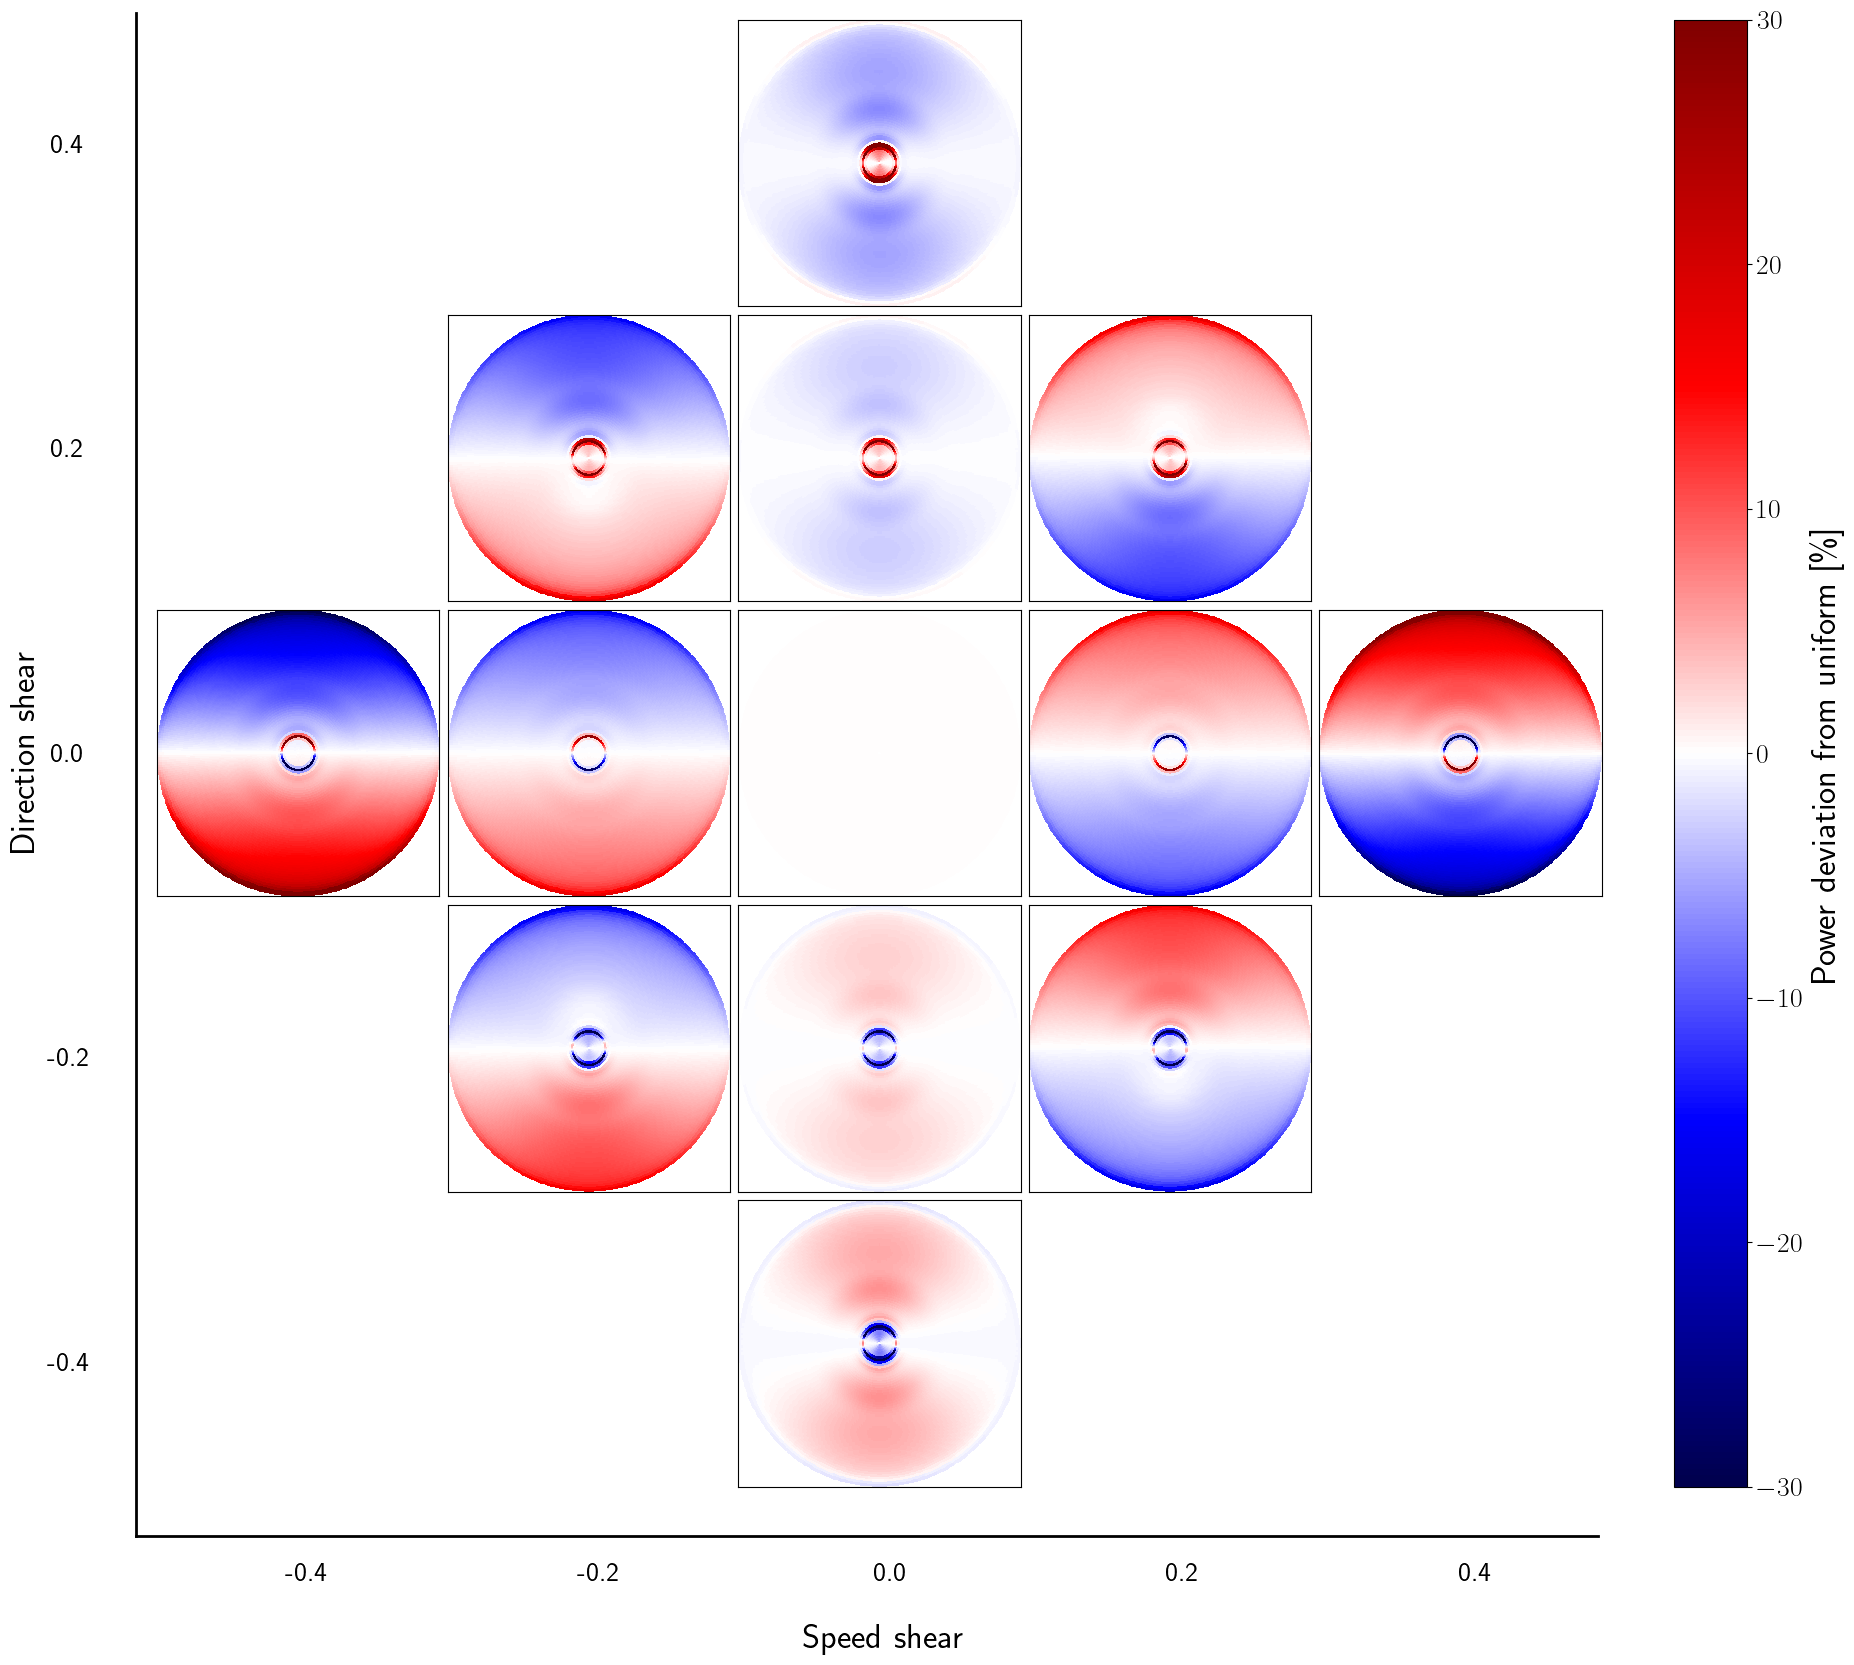

In [37]:
# POWER DEVIATION

xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]


fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(17, 15), constrained_layout=True,sharex=True, sharey=True)
    
ref_case = ((0.5 * 3 * 1.225 * rotor.chord_func(solutions[ref].geom.mu) * ((solutions[ref].W('sector') * 7)**2 * solutions[ref].Ctan('sector')).T) * solutions[ref].geom.mu * rotor.R * solutions[ref].tsr * 7 / rotor.R).T

for i in range(len(xs)):
    current = ((0.5 * 3 * 1.225 * rotor.chord_func(solutions[i].geom.mu) * ((solutions[i].W('sector') * 7)**2 * solutions[i].Ctan('sector')).T) * solutions[i].geom.mu * rotor.R * solutions[i].tsr * 7 / rotor.R).T
    mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic', vmin = -30, vmax = 30)
    # ax[xs[i],ys[i]].invert_yaxis()
    ax[xs[i],ys[i]].set_xticklabels([])
    ax[xs[i],ys[i]].set_yticklabels([])
    ax[xs[i],ys[i]].set_xticks([])
    ax[xs[i],ys[i]].set_yticks([])


ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
ax[4,4].axis('off')

# Add a single colorbar on the right-hand side
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('Power deviation from uniform [\%]',fontsize=25)

# Add the number line below the subplots
line_y = -0.02  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.01, 0.85  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.1  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.43, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)


line_x = -0.01  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.02, 0.995  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.11  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.03,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.44, 'Direction shear', ha='center', fontsize=25,rotation=90)

plt.show()

/tmp/ipykernel_196613/4209019766.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, current, cmap='viridis',vmin=0.33,vmax=0.42)
/tmp/ipykernel_196613/4209019766.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, current, cmap='viridis',vmin=0.33,vmax=0.42)
/tmp/ipykernel_196613/4209019766.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell

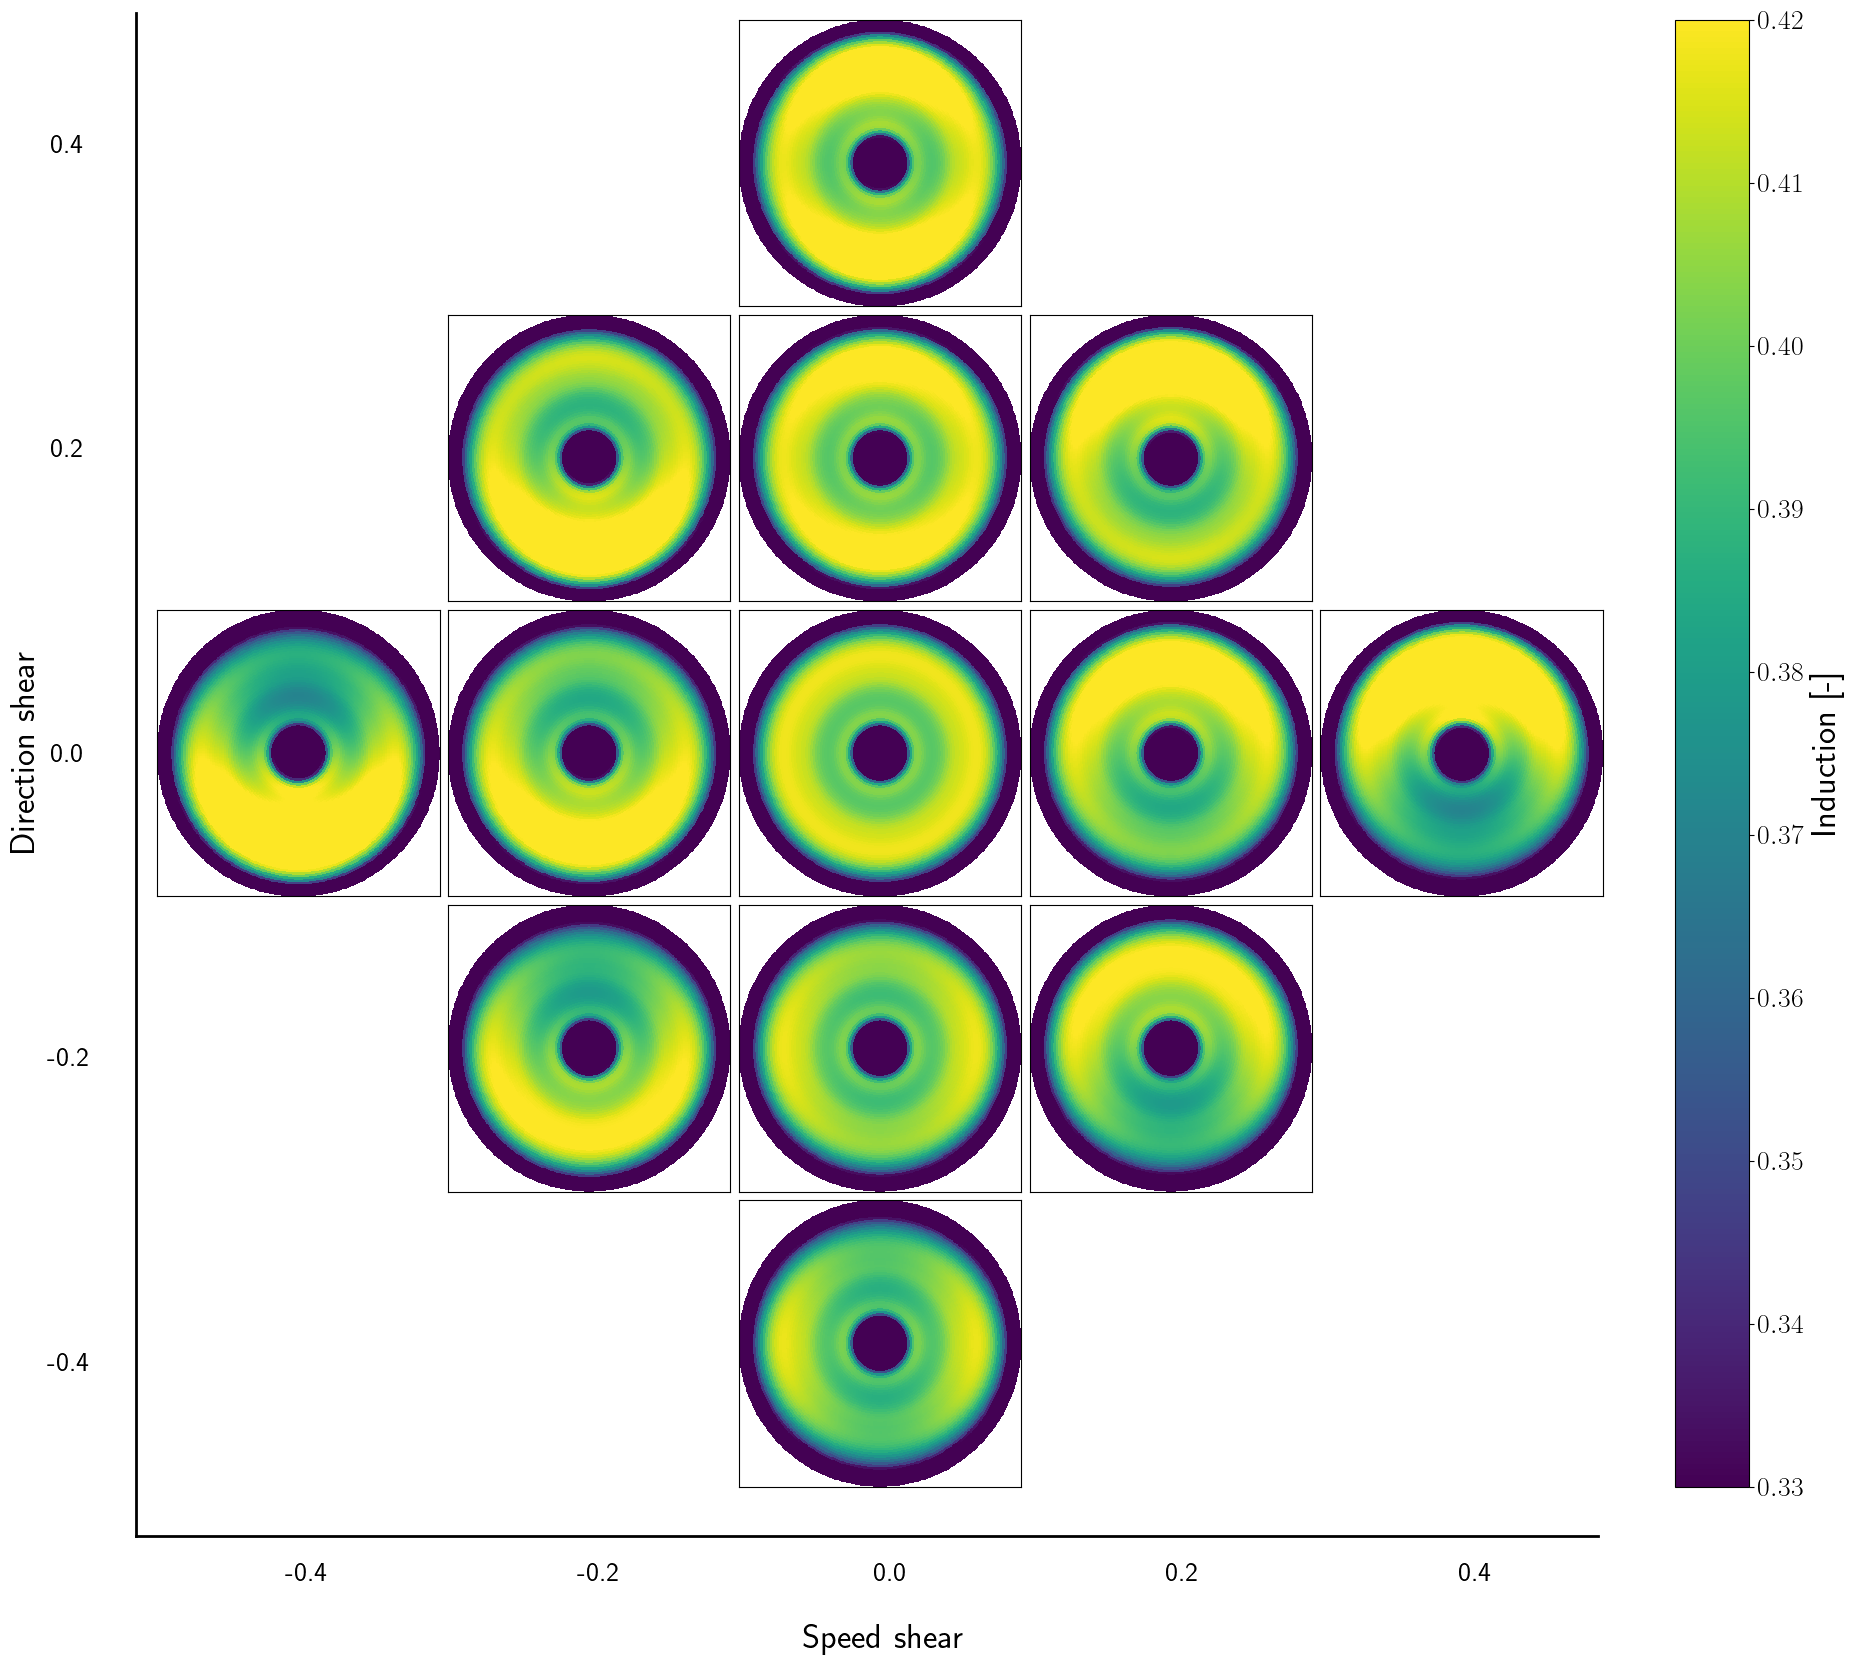

In [ ]:
# INDUCTION DIMENSIONAL

xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(17, 15), constrained_layout=True,sharex=True, sharey=True)
    
# ref_case = (1- (solutions[ref].U('sector') * np.cos(solutions[ref].wdir('sector')))) 
ref_case = solutions[ref].a('sector')

for i in range(len(xs)):
    current = solutions[i].a('sector')
    # mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-75,vmax=75)
    mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, current, cmap='viridis',vmin=0.33,vmax=0.42)

    # ax[xs[i],ys[i]].invert_yaxis()
    ax[xs[i],ys[i]].set_xticklabels([])
    ax[xs[i],ys[i]].set_yticklabels([])
    ax[xs[i],ys[i]].set_xticks([])
    ax[xs[i],ys[i]].set_yticks([])

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
ax[4,4].axis('off')

# Add a single colorbar on the right-hand side
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('Induction [-]',fontsize=25)




# Add the number line below the subplots
line_y = -0.02  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.01, 0.85  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.1  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.43, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)


line_x = -0.01  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.02, 0.995  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.11  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.03,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.44, 'Direction shear', ha='center', fontsize=25,rotation=90)

plt.show()

/tmp/ipykernel_210160/4270756863.py:55: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, current, cmap='viridis',vmin=0.33,vmax=0.42)
/tmp/ipykernel_210160/4270756863.py:55: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, current, cmap='viridis',vmin=0.33,vmax=0.42)
/tmp/ipykernel_210160/4270756863.py:55: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell

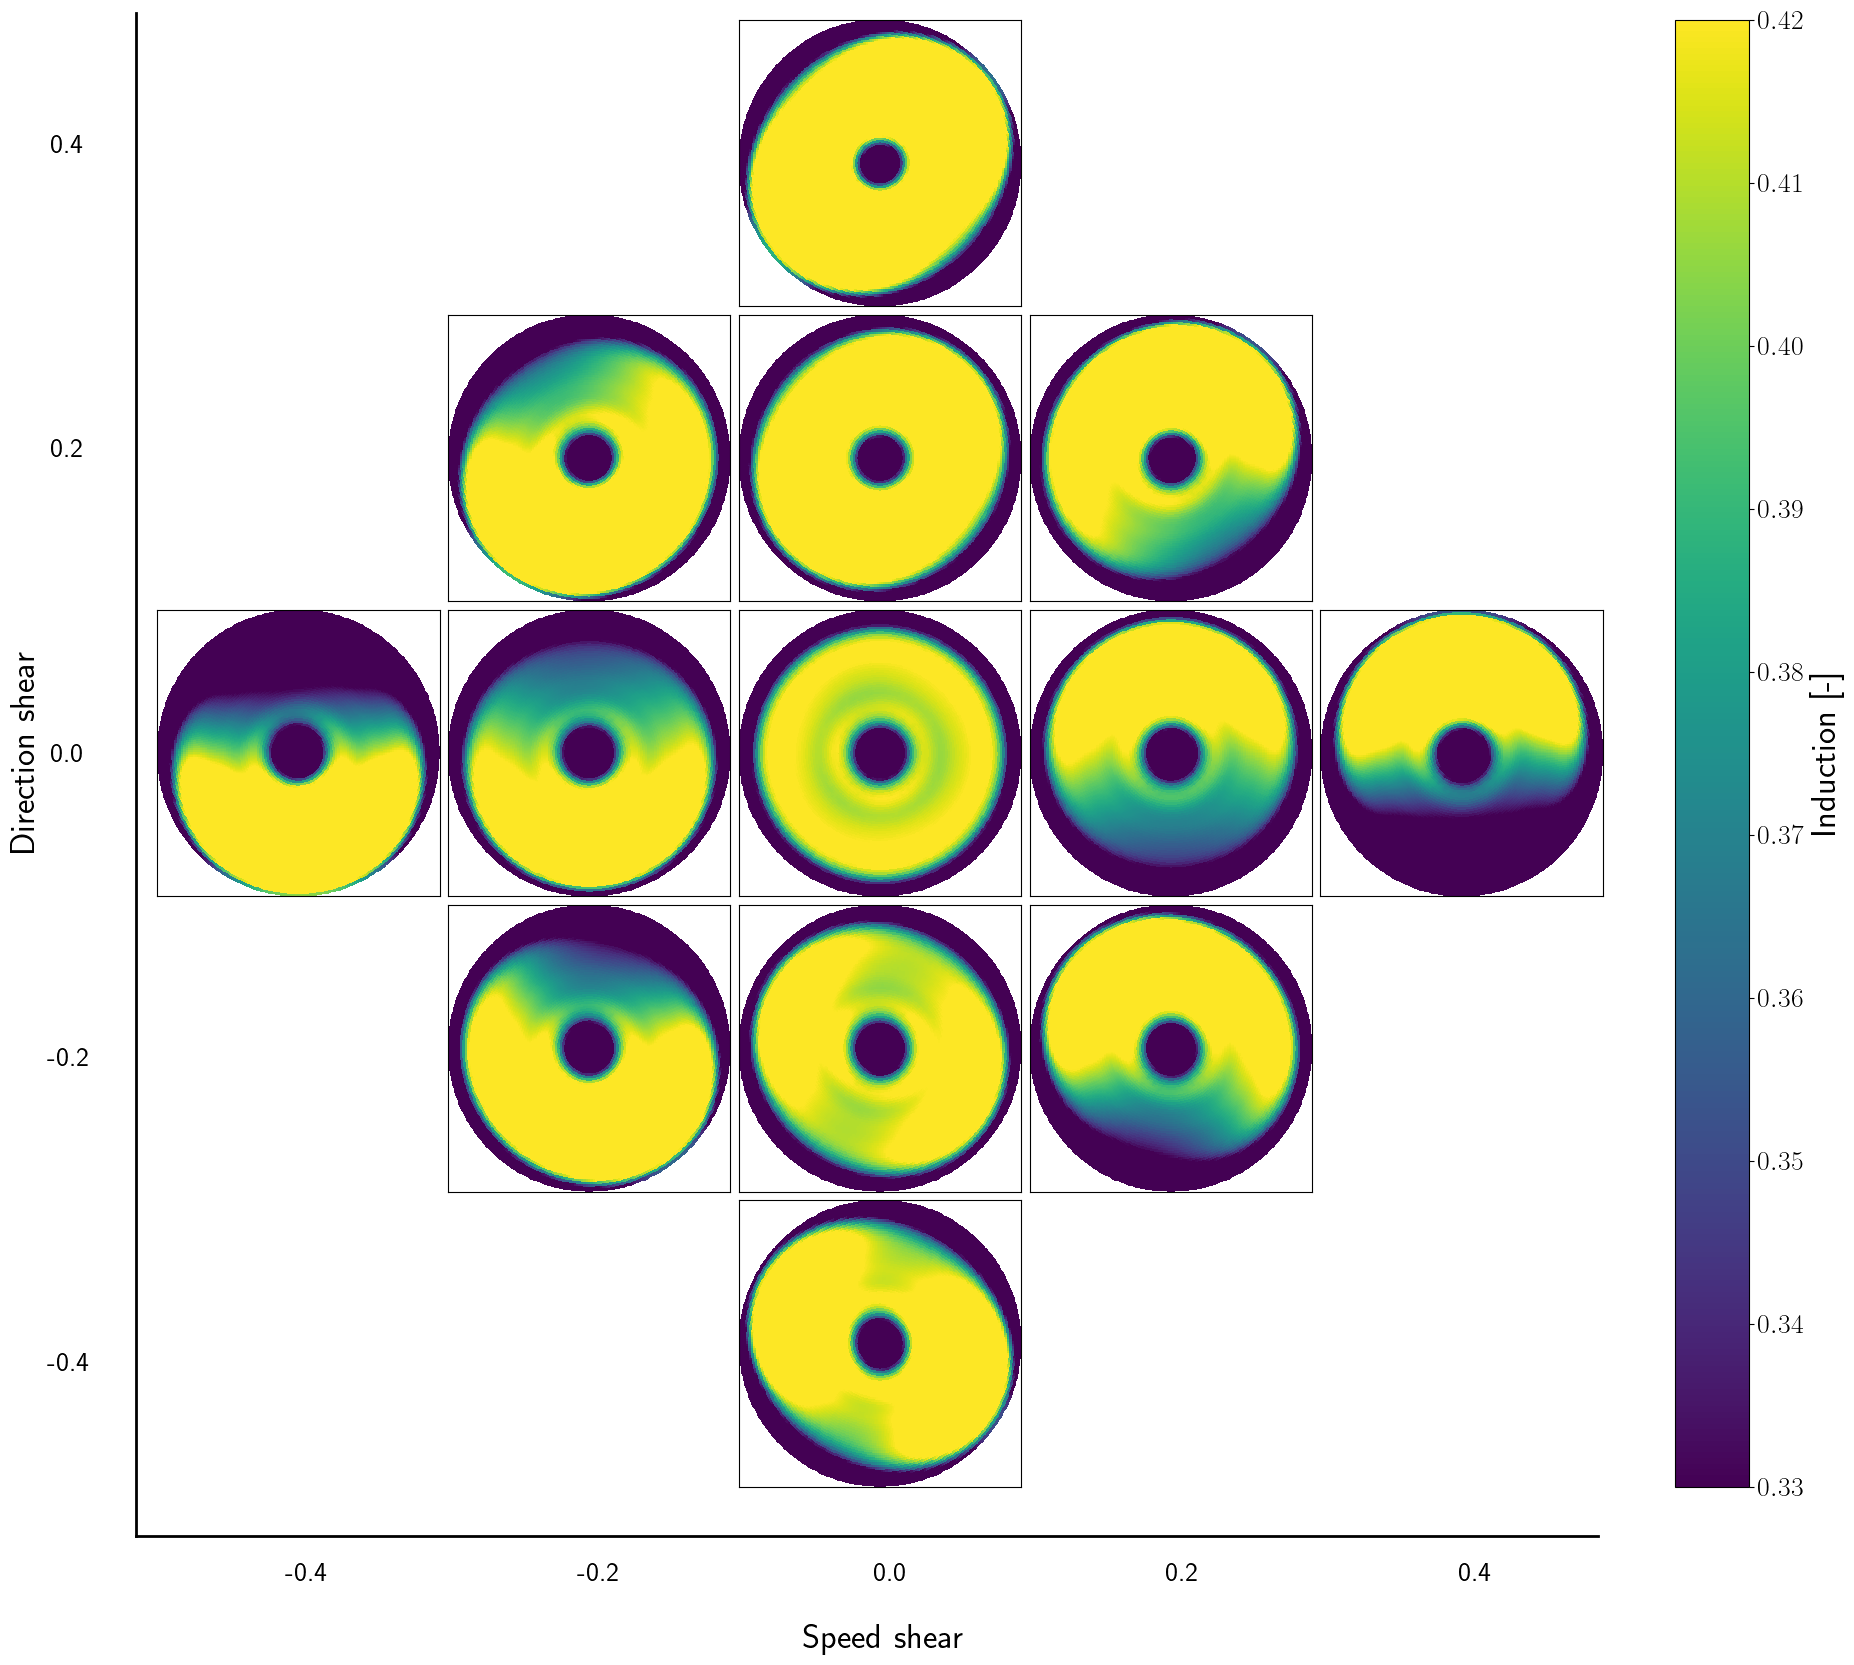

In [20]:
# INDUCTION DIMENSIONAL WRF

xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(17, 15), constrained_layout=True,sharex=True, sharey=True)
    
# ref_case = (1- aoa_rt.T/wrfles_data[count]['uinf'])

for i in range(len(xs)):

    y = (wrfles_data[i]['Y3'] - wrfles_data[i]['rotor_yloc'])/(wrfles_data[i]['diameter']/2)
    z = (wrfles_data[i]['Z3'] - wrfles_data[i]['hub_height'])/(wrfles_data[i]['diameter']/2)

    r     = (y**2 + z**2)**(1/2)
    theta = np.arctan2(y,z)

    ws  = ((np.mean(wrfles_data[i]['ux_0D'], axis=0)**2 + np.mean(wrfles_data[i]['vx_0D'], axis=0)**2)**(1/2) / wrfles_data[i]['uinf'])
    wd  = (np.arctan2(np.mean(wrfles_data[i]['vx_0D'], axis=0), np.mean(wrfles_data[i]['ux_0D'], axis=0)))

    Ad = np.pi * (wrfles_data[i]['diameter']/2)**2

    # Mask points where r > R
    mask = r <= 1.5
    r_filtered     = r[mask]
    theta_filtered = theta[mask]
    ws_filtered    = ws[mask]
    wd_filtered    = wd[mask]

    # Interpolate to new polar grid
    r_new = np.linspace(0.0, 0.99999, 60)  # 50 points in r
    theta_new = np.linspace(0, 2 * np.pi, 360)  # 100 points in theta
    Theta_new, R_new = np.meshgrid(theta_new, r_new)

    # Convert new polar grid to Cartesian for interpolation
    X_new = R_new * np.sin(Theta_new)
    Y_new = R_new * np.cos(Theta_new)

    # Interpolate data to the new polar grid
    ws_rt = griddata(
        points=(y[mask], z[mask]),
        values=ws_filtered,
        xi=(X_new, Y_new),
        method='linear'
    )
    # Interpolate data to the new polar grid
    wd_rt = griddata(
        points=(y[mask], z[mask]),
        values=wd_filtered,
        xi=(X_new, Y_new),
        method='linear'
    )

    current = (1- (ws_rt * wrfles_data[i]['uinf'] * np.cos(wd_rt))/wrfles_data[i]['uinf'])
    mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, current, cmap='viridis',vmin=0.33,vmax=0.42)

    ax[xs[i],ys[i]].invert_yaxis()
    ax[xs[i],ys[i]].set_xticklabels([])
    ax[xs[i],ys[i]].set_yticklabels([])
    ax[xs[i],ys[i]].set_xticks([])
    ax[xs[i],ys[i]].set_yticks([])

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
ax[4,4].axis('off')

# Add a single colorbar on the right-hand side
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('Induction [-]',fontsize=25)




# Add the number line below the subplots
line_y = -0.02  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.01, 0.85  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.1  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.43, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)


line_x = -0.01  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.02, 0.995  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.11  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.03,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.44, 'Direction shear', ha='center', fontsize=25,rotation=90)

plt.show()

/tmp/ipykernel_210160/2210692175.py:97: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='Spectral',vmin=-10,vmax=10)
/tmp/ipykernel_210160/2210692175.py:97: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='Spectral',vmin=-10,vmax=10)
/tmp/ipykernel_210160/2210692175.py:97: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or 

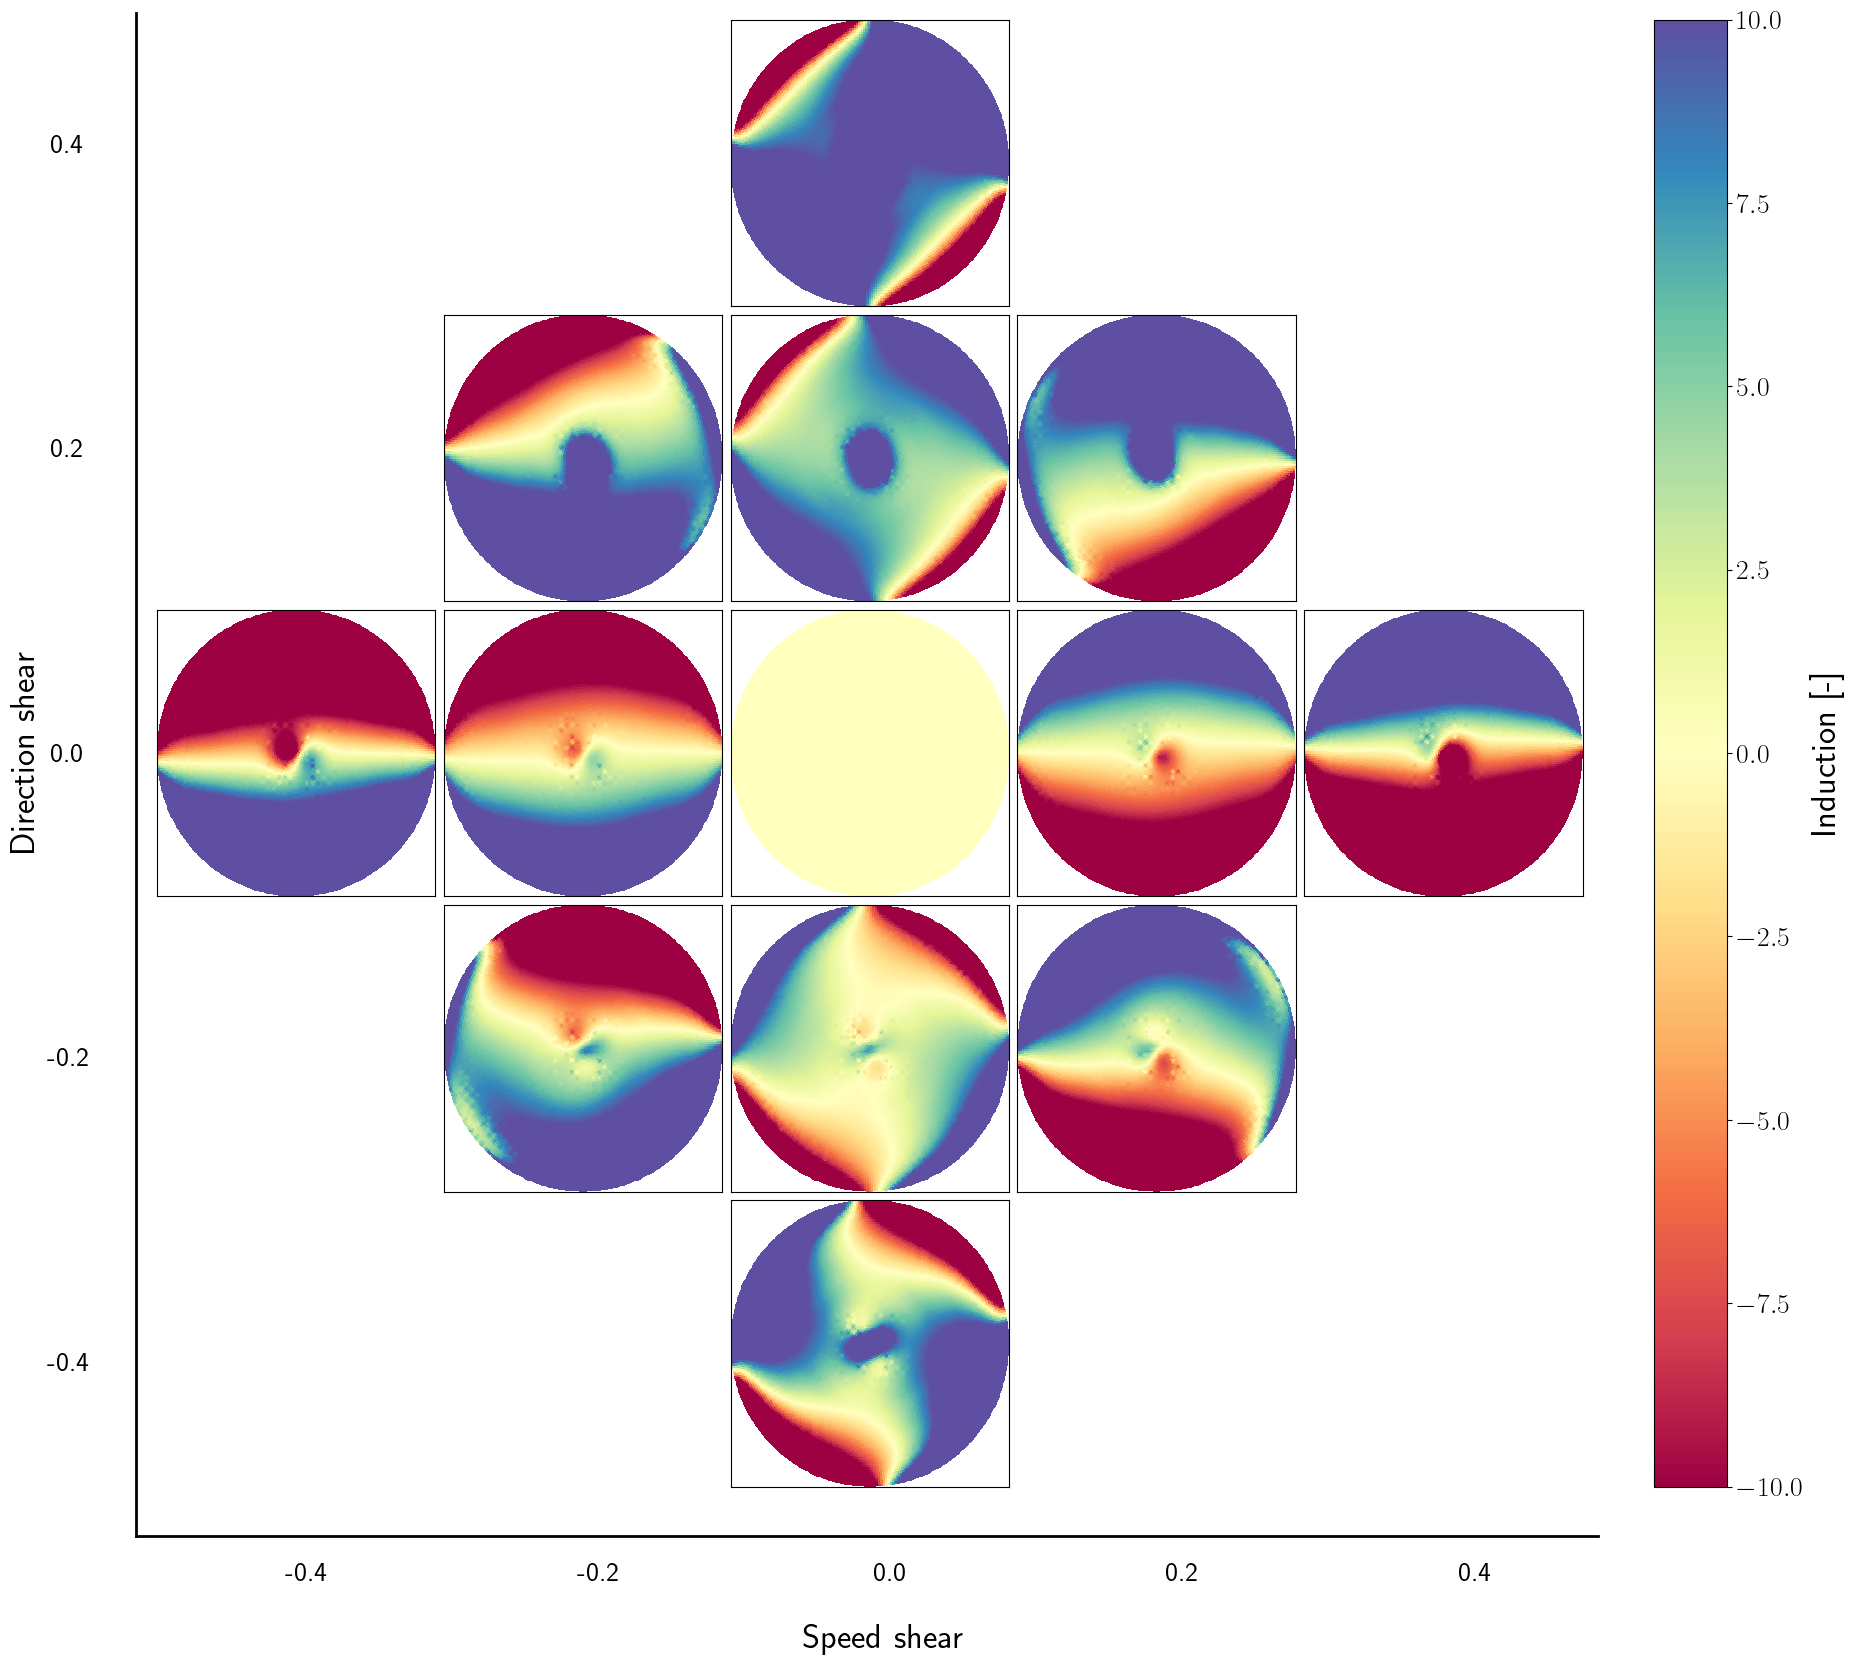

In [30]:
# INDUCTION DEVITATION WRF 

xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(17, 15), constrained_layout=True,sharex=True, sharey=True)
    

y = (wrfles_data[ref]['Y3'] - wrfles_data[ref]['rotor_yloc'])/(wrfles_data[ref]['diameter']/2)
z = (wrfles_data[ref]['Z3'] - wrfles_data[ref]['hub_height'])/(wrfles_data[ref]['diameter']/2)

r     = (y**2 + z**2)**(1/2)
theta = np.arctan2(y,z)

ws  = ((np.mean(wrfles_data[ref]['ux_0D'], axis=0)**2 + np.mean(wrfles_data[ref]['vx_0D'], axis=0)**2)**(1/2) / wrfles_data[ref]['uinf'])
wd  = (np.arctan2(np.mean(wrfles_data[ref]['vx_0D'], axis=0), np.mean(wrfles_data[ref]['ux_0D'], axis=0)))

Ad = np.pi * (wrfles_data[ref]['diameter']/2)**2

# Mask points where r > R
mask = r <= 1.5
r_filtered     = r[mask]
theta_filtered = theta[mask]
ws_filtered    = ws[mask]
wd_filtered    = wd[mask]

# Interpolate to new polar grid
r_new = np.linspace(0.0, 0.99999, 60)  # 50 points in r
theta_new = np.linspace(0, 2 * np.pi, 360)  # 100 points in theta
Theta_new, R_new = np.meshgrid(theta_new, r_new)

# Convert new polar grid to Cartesian for interpolation
X_new = R_new * np.sin(Theta_new)
Y_new = R_new * np.cos(Theta_new)

# Interpolate data to the new polar grid
ws_rt = griddata(
    points=(y[mask], z[mask]),
    values=ws_filtered,
    xi=(X_new, Y_new),
    method='linear'
)
# Interpolate data to the new polar grid
wd_rt = griddata(
    points=(y[mask], z[mask]),
    values=wd_filtered,
    xi=(X_new, Y_new),
    method='linear'
)
ref_case = (1- (ws_rt * wrfles_data[ref]['uinf'] * np.cos(wd_rt))/wrfles_data[ref]['uinf'])

for i in range(len(xs)):

    y = (wrfles_data[i]['Y3'] - wrfles_data[i]['rotor_yloc'])/(wrfles_data[i]['diameter']/2)
    z = (wrfles_data[i]['Z3'] - wrfles_data[i]['hub_height'])/(wrfles_data[i]['diameter']/2)

    r     = (y**2 + z**2)**(1/2)
    theta = np.arctan2(y,z)

    ws  = ((np.mean(wrfles_data[i]['ux_0D'], axis=0)**2 + np.mean(wrfles_data[i]['vx_0D'], axis=0)**2)**(1/2) / wrfles_data[i]['uinf'])
    wd  = (np.arctan2(np.mean(wrfles_data[i]['vx_0D'], axis=0), np.mean(wrfles_data[i]['ux_0D'], axis=0)))

    Ad = np.pi * (wrfles_data[i]['diameter']/2)**2

    # Mask points where r > R
    mask = r <= 1.5
    r_filtered     = r[mask]
    theta_filtered = theta[mask]
    ws_filtered    = ws[mask]
    wd_filtered    = wd[mask]

    # Interpolate to new polar grid
    r_new = np.linspace(0.0, 0.99999, 60)  # 50 points in r
    theta_new = np.linspace(0, 2 * np.pi, 360)  # 100 points in theta
    Theta_new, R_new = np.meshgrid(theta_new, r_new)

    # Convert new polar grid to Cartesian for interpolation
    X_new = R_new * np.sin(Theta_new)
    Y_new = R_new * np.cos(Theta_new)

    # Interpolate data to the new polar grid
    ws_rt = griddata(
        points=(y[mask], z[mask]),
        values=ws_filtered,
        xi=(X_new, Y_new),
        method='linear'
    )
    # Interpolate data to the new polar grid
    wd_rt = griddata(
        points=(y[mask], z[mask]),
        values=wd_filtered,
        xi=(X_new, Y_new),
        method='linear'
    )

    current = (1- (ws_rt * wrfles_data[i]['uinf'] * np.cos(wd_rt))/wrfles_data[i]['uinf'])
    mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='Spectral',vmin=-10,vmax=10)

    ax[xs[i],ys[i]].invert_yaxis()
    ax[xs[i],ys[i]].set_xticklabels([])
    ax[xs[i],ys[i]].set_yticklabels([])
    ax[xs[i],ys[i]].set_xticks([])
    ax[xs[i],ys[i]].set_yticks([])

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
ax[4,4].axis('off')

# Add a single colorbar on the right-hand side
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('Induction [-]',fontsize=25)




# Add the number line below the subplots
line_y = -0.02  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.01, 0.85  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.1  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.43, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)


line_x = -0.01  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.02, 0.995  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.11  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.03,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.44, 'Direction shear', ha='center', fontsize=25,rotation=90)

plt.show()

/tmp/ipykernel_196613/3111391499.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='Spectral',vmin=-10,vmax=10)
/tmp/ipykernel_196613/3111391499.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='Spectral',vmin=-10,vmax=10)
/tmp/ipykernel_196613/3111391499.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or 

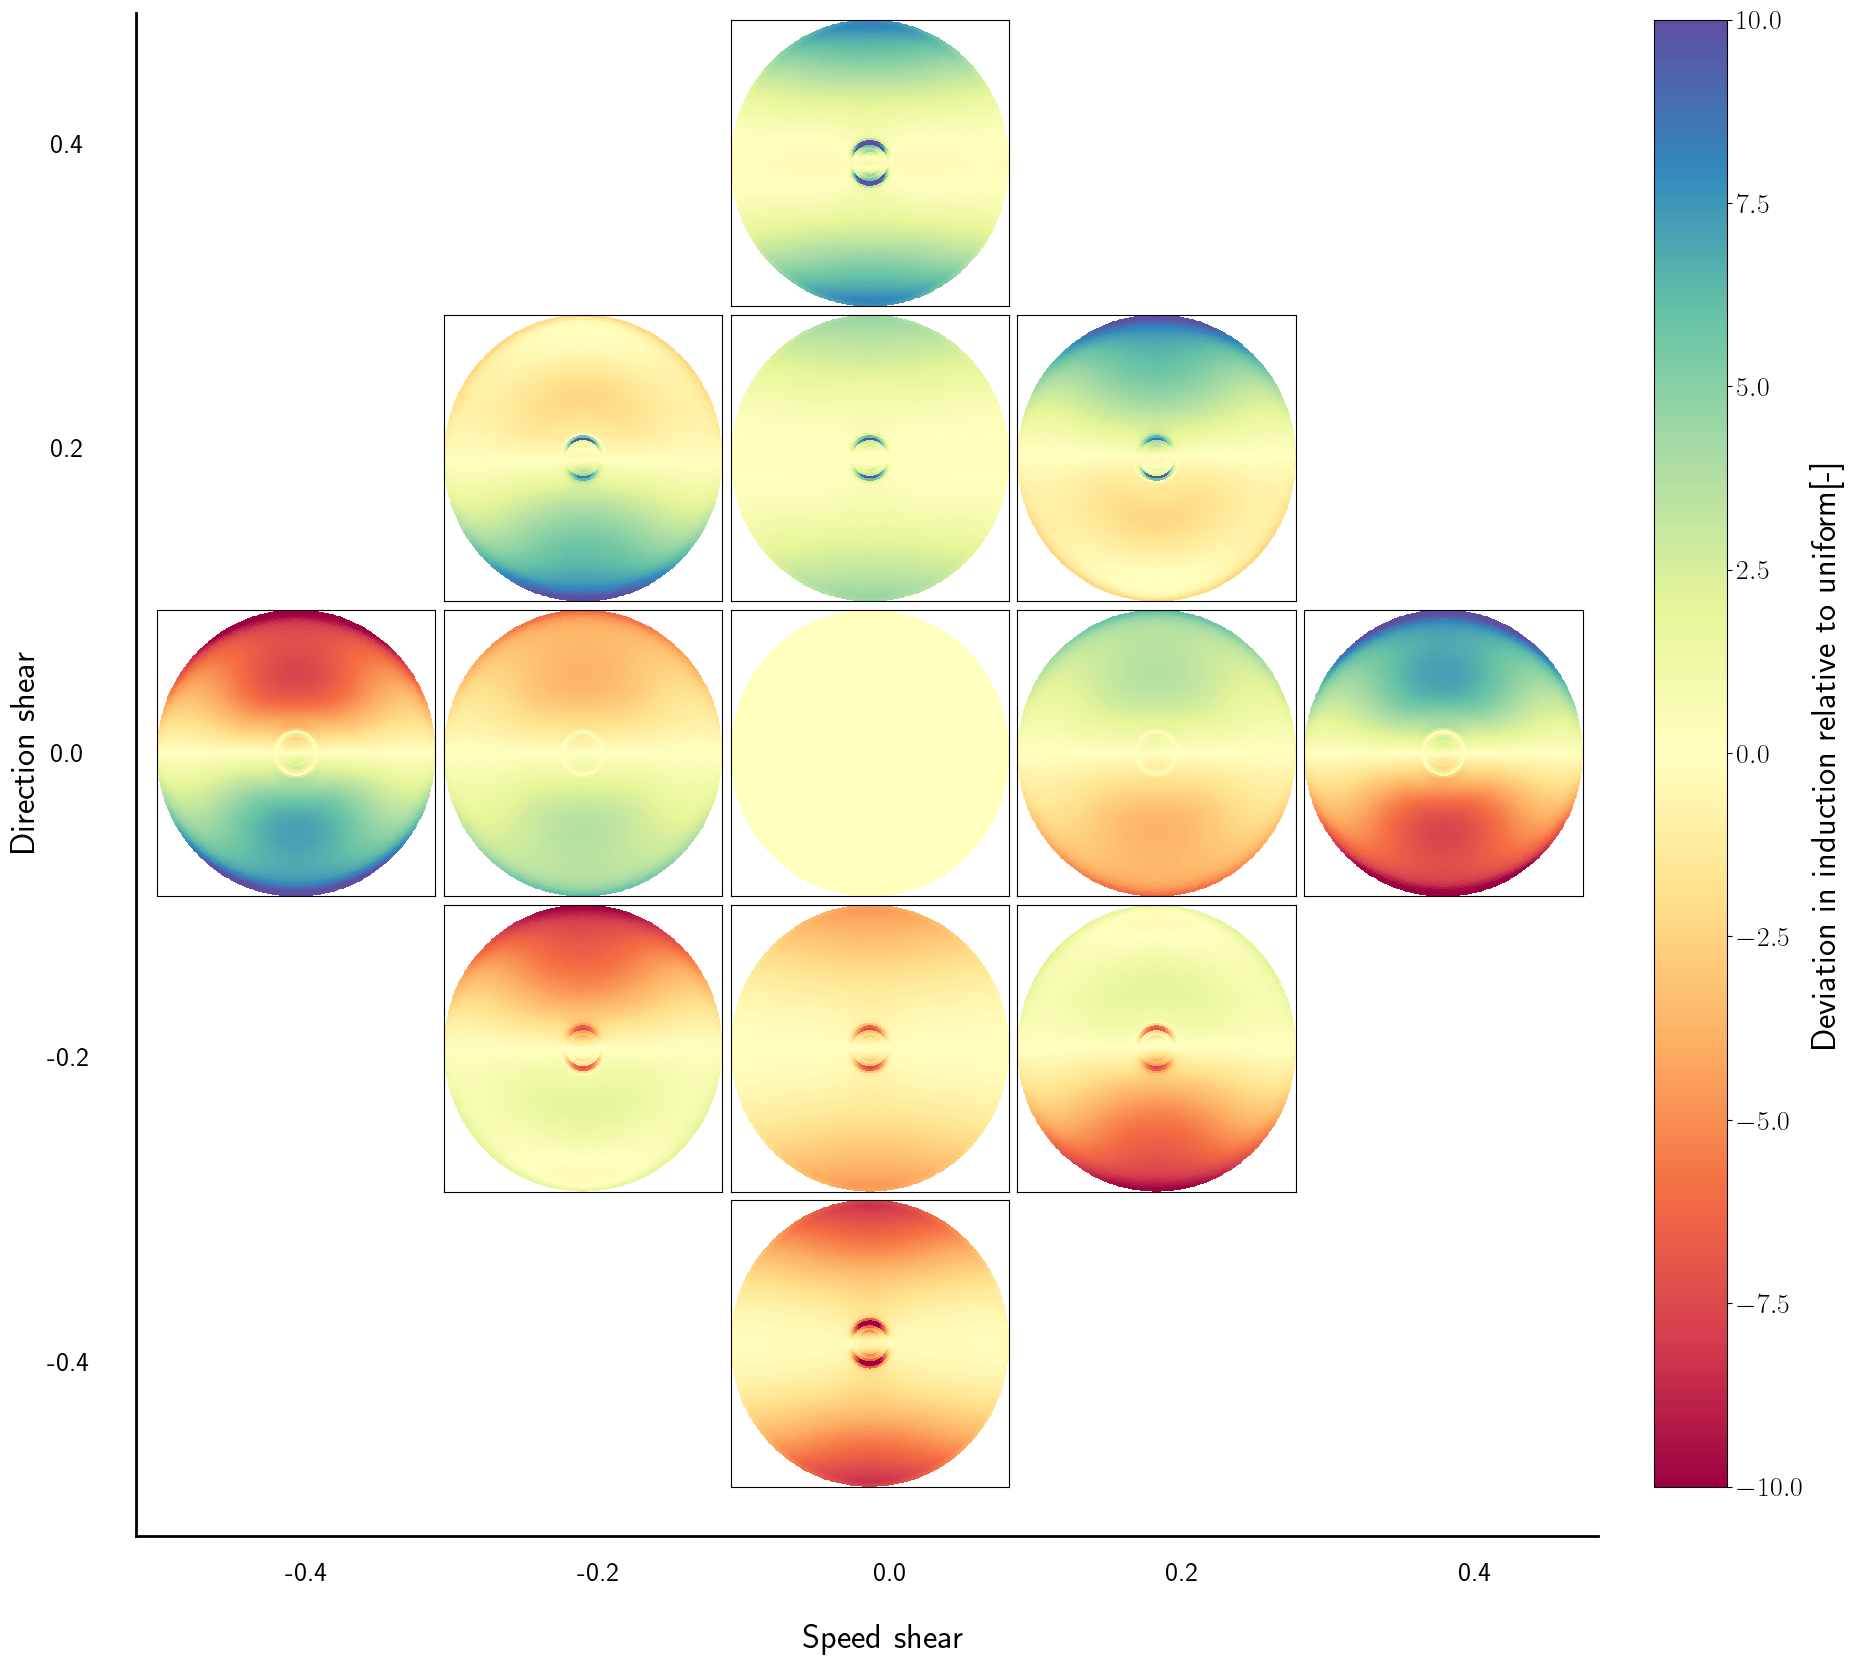

In [30]:
# INDUCTION DEVIATION

xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(17, 15), constrained_layout=True,sharex=True, sharey=True)
    
# ref_case = (1- (solutions[ref].U('sector') * np.cos(solutions[ref].wdir('sector')))) 
ref_case = solutions[ref].a('sector')

for i in range(len(xs)):
    current = solutions[i].a('sector')
    # mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-75,vmax=75)
    mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='Spectral',vmin=-10,vmax=10)

    # ax[xs[i],ys[i]].invert_yaxis()
    ax[xs[i],ys[i]].set_xticklabels([])
    ax[xs[i],ys[i]].set_yticklabels([])
    ax[xs[i],ys[i]].set_xticks([])
    ax[xs[i],ys[i]].set_yticks([])

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
ax[4,4].axis('off')

# Add a single colorbar on the right-hand side
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('Deviation in induction relative to uniform[-]',fontsize=25)




# Add the number line below the subplots
line_y = -0.02  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.01, 0.85  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.1  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.43, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)


line_x = -0.01  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.02, 0.995  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.11  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.03,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.44, 'Direction shear', ha='center', fontsize=25,rotation=90)

plt.show()

/tmp/ipykernel_2353449/3114637918.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, solutions[i].aoa('sector')*180/np.pi, cmap='viridis',vmin=1,vmax=8)
/tmp/ipykernel_2353449/3114637918.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, solutions[i].aoa('sector')*180/np.pi, cmap='viridis',vmin=1,vmax=8)
/tmp/ipykernel_2353449/3114637918.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing

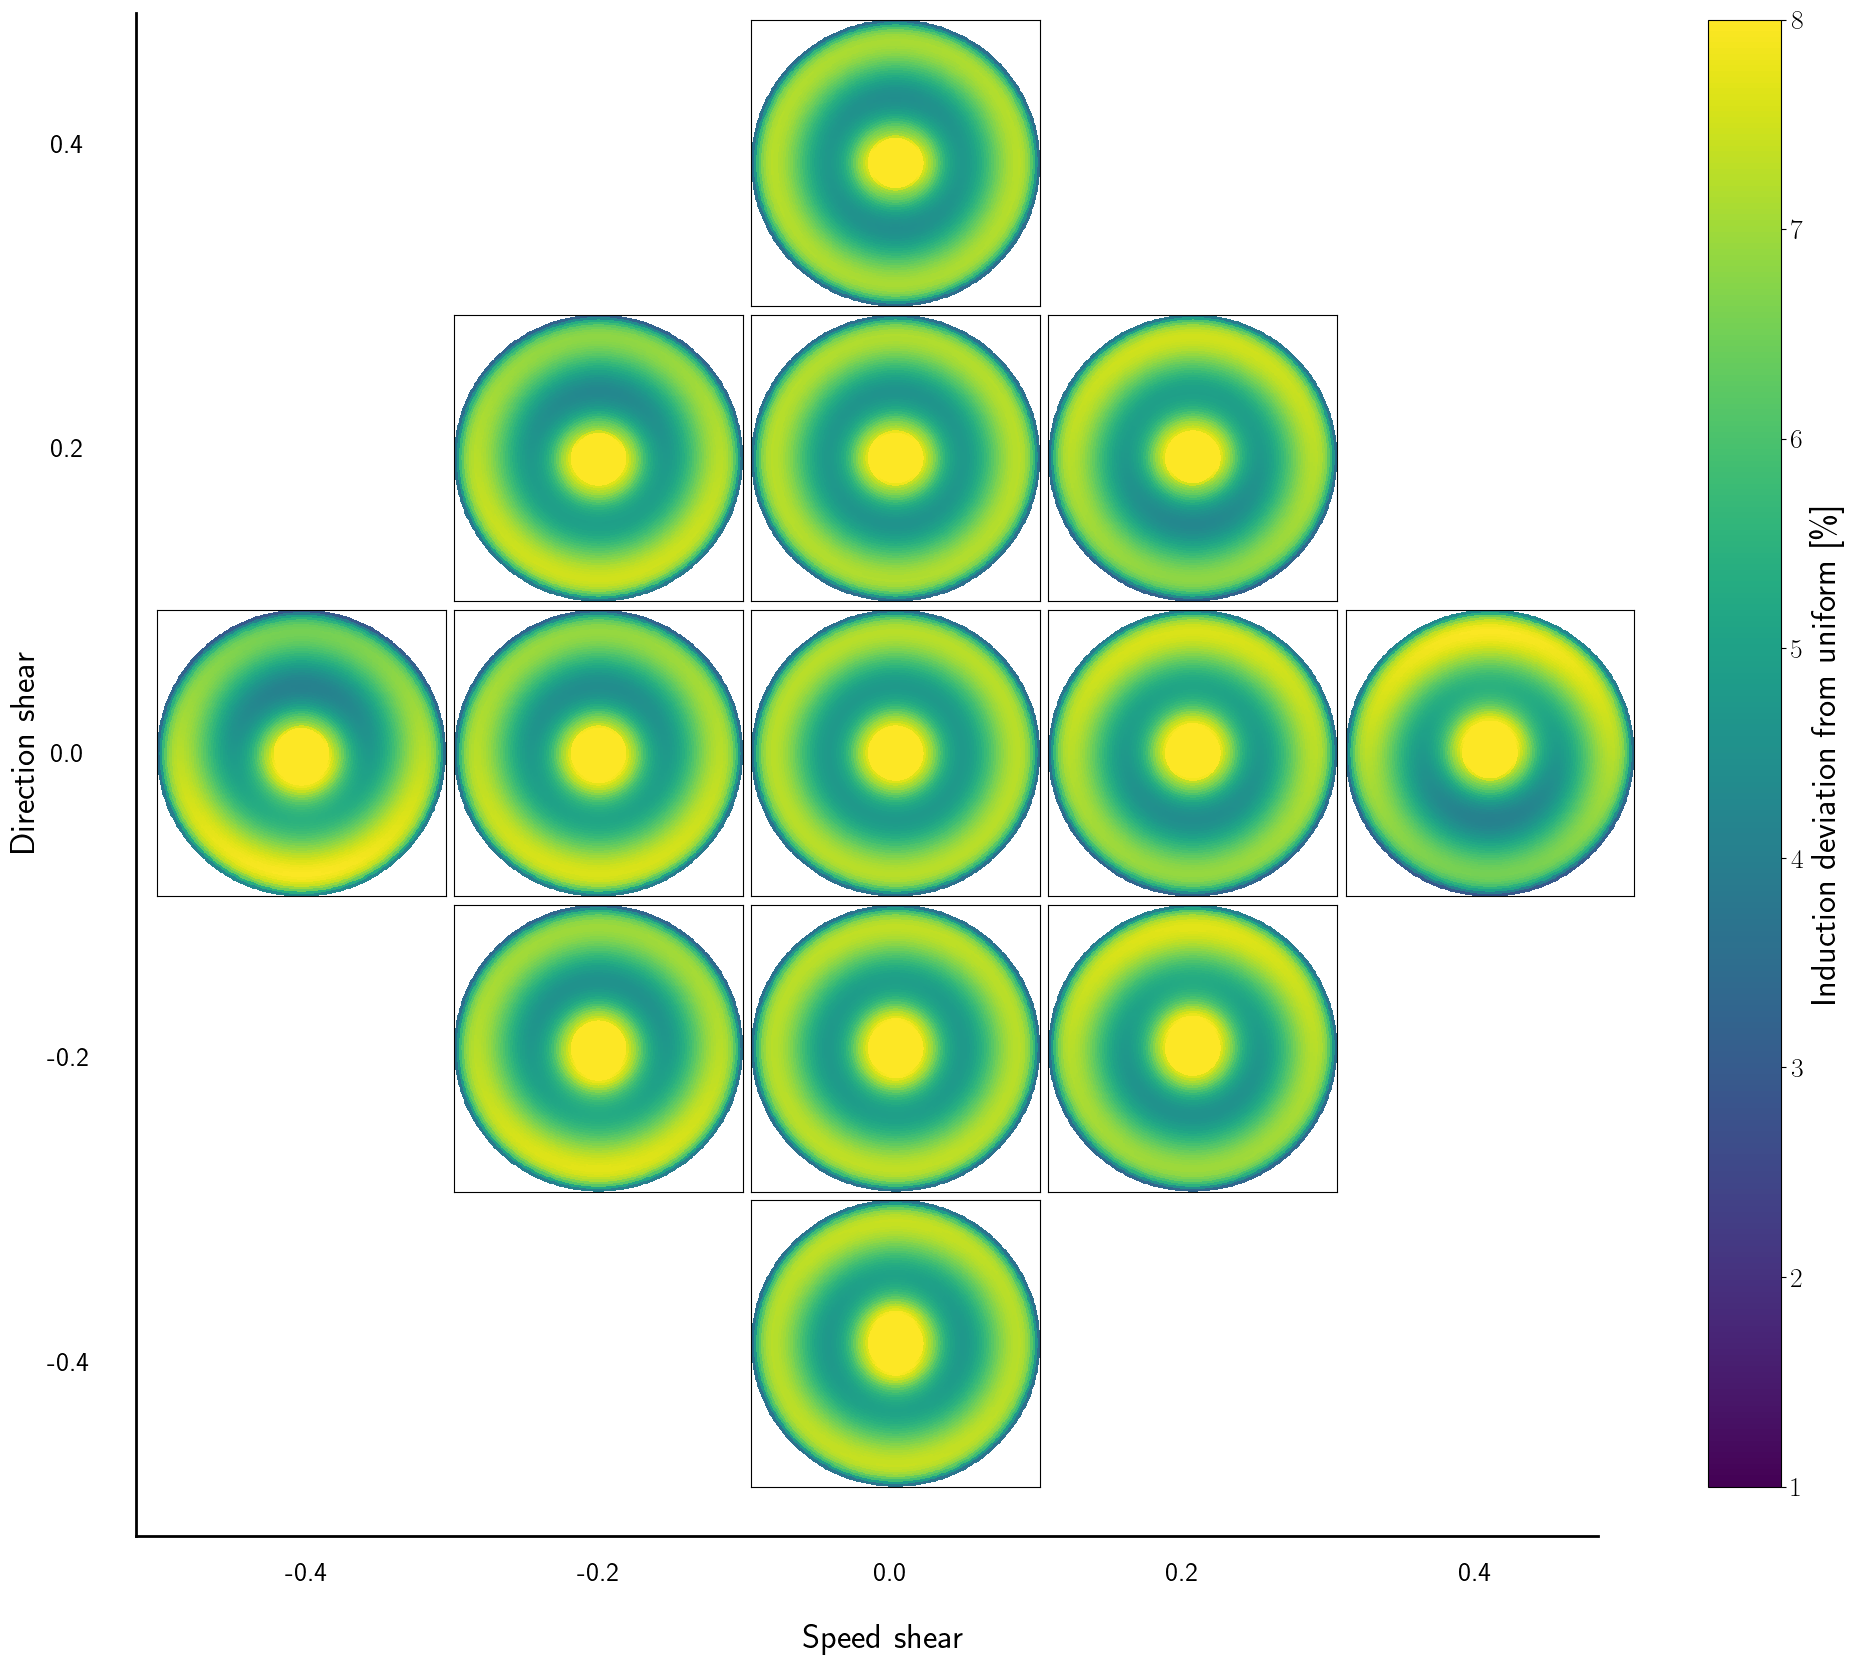

In [54]:

xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(17, 15), constrained_layout=True,sharex=True, sharey=True)
    
for i in range(len(xs)):
    current = (1- (solutions[i].U('sector') * np.cos(solutions[i].wdir('sector')))) 
    mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, solutions[i].aoa('sector')*180/np.pi, cmap='viridis',vmin=1,vmax=8)
    # ax[xs[i],ys[i]].invert_yaxis()
    ax[xs[i],ys[i]].set_xticklabels([])
    ax[xs[i],ys[i]].set_yticklabels([])
    ax[xs[i],ys[i]].set_xticks([])
    ax[xs[i],ys[i]].set_yticks([])

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
ax[4,4].axis('off')

# Add a single colorbar on the right-hand side
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('Induction deviation from uniform [\%]',fontsize=25)




# Add the number line below the subplots
line_y = -0.02  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.01, 0.85  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.1  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.43, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)


line_x = -0.01  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.02, 0.995  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.11  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.03,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.44, 'Direction shear', ha='center', fontsize=25,rotation=90)

plt.show()

/tmp/ipykernel_2353449/4239905176.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-10,vmax=10)
/tmp/ipykernel_2353449/4239905176.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-10,vmax=10)
/tmp/ipykernel_2353449/4239905176.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or

/tmp/ipykernel_2353449/4239905176.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-10,vmax=10)
/tmp/ipykernel_2353449/4239905176.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-10,vmax=10)


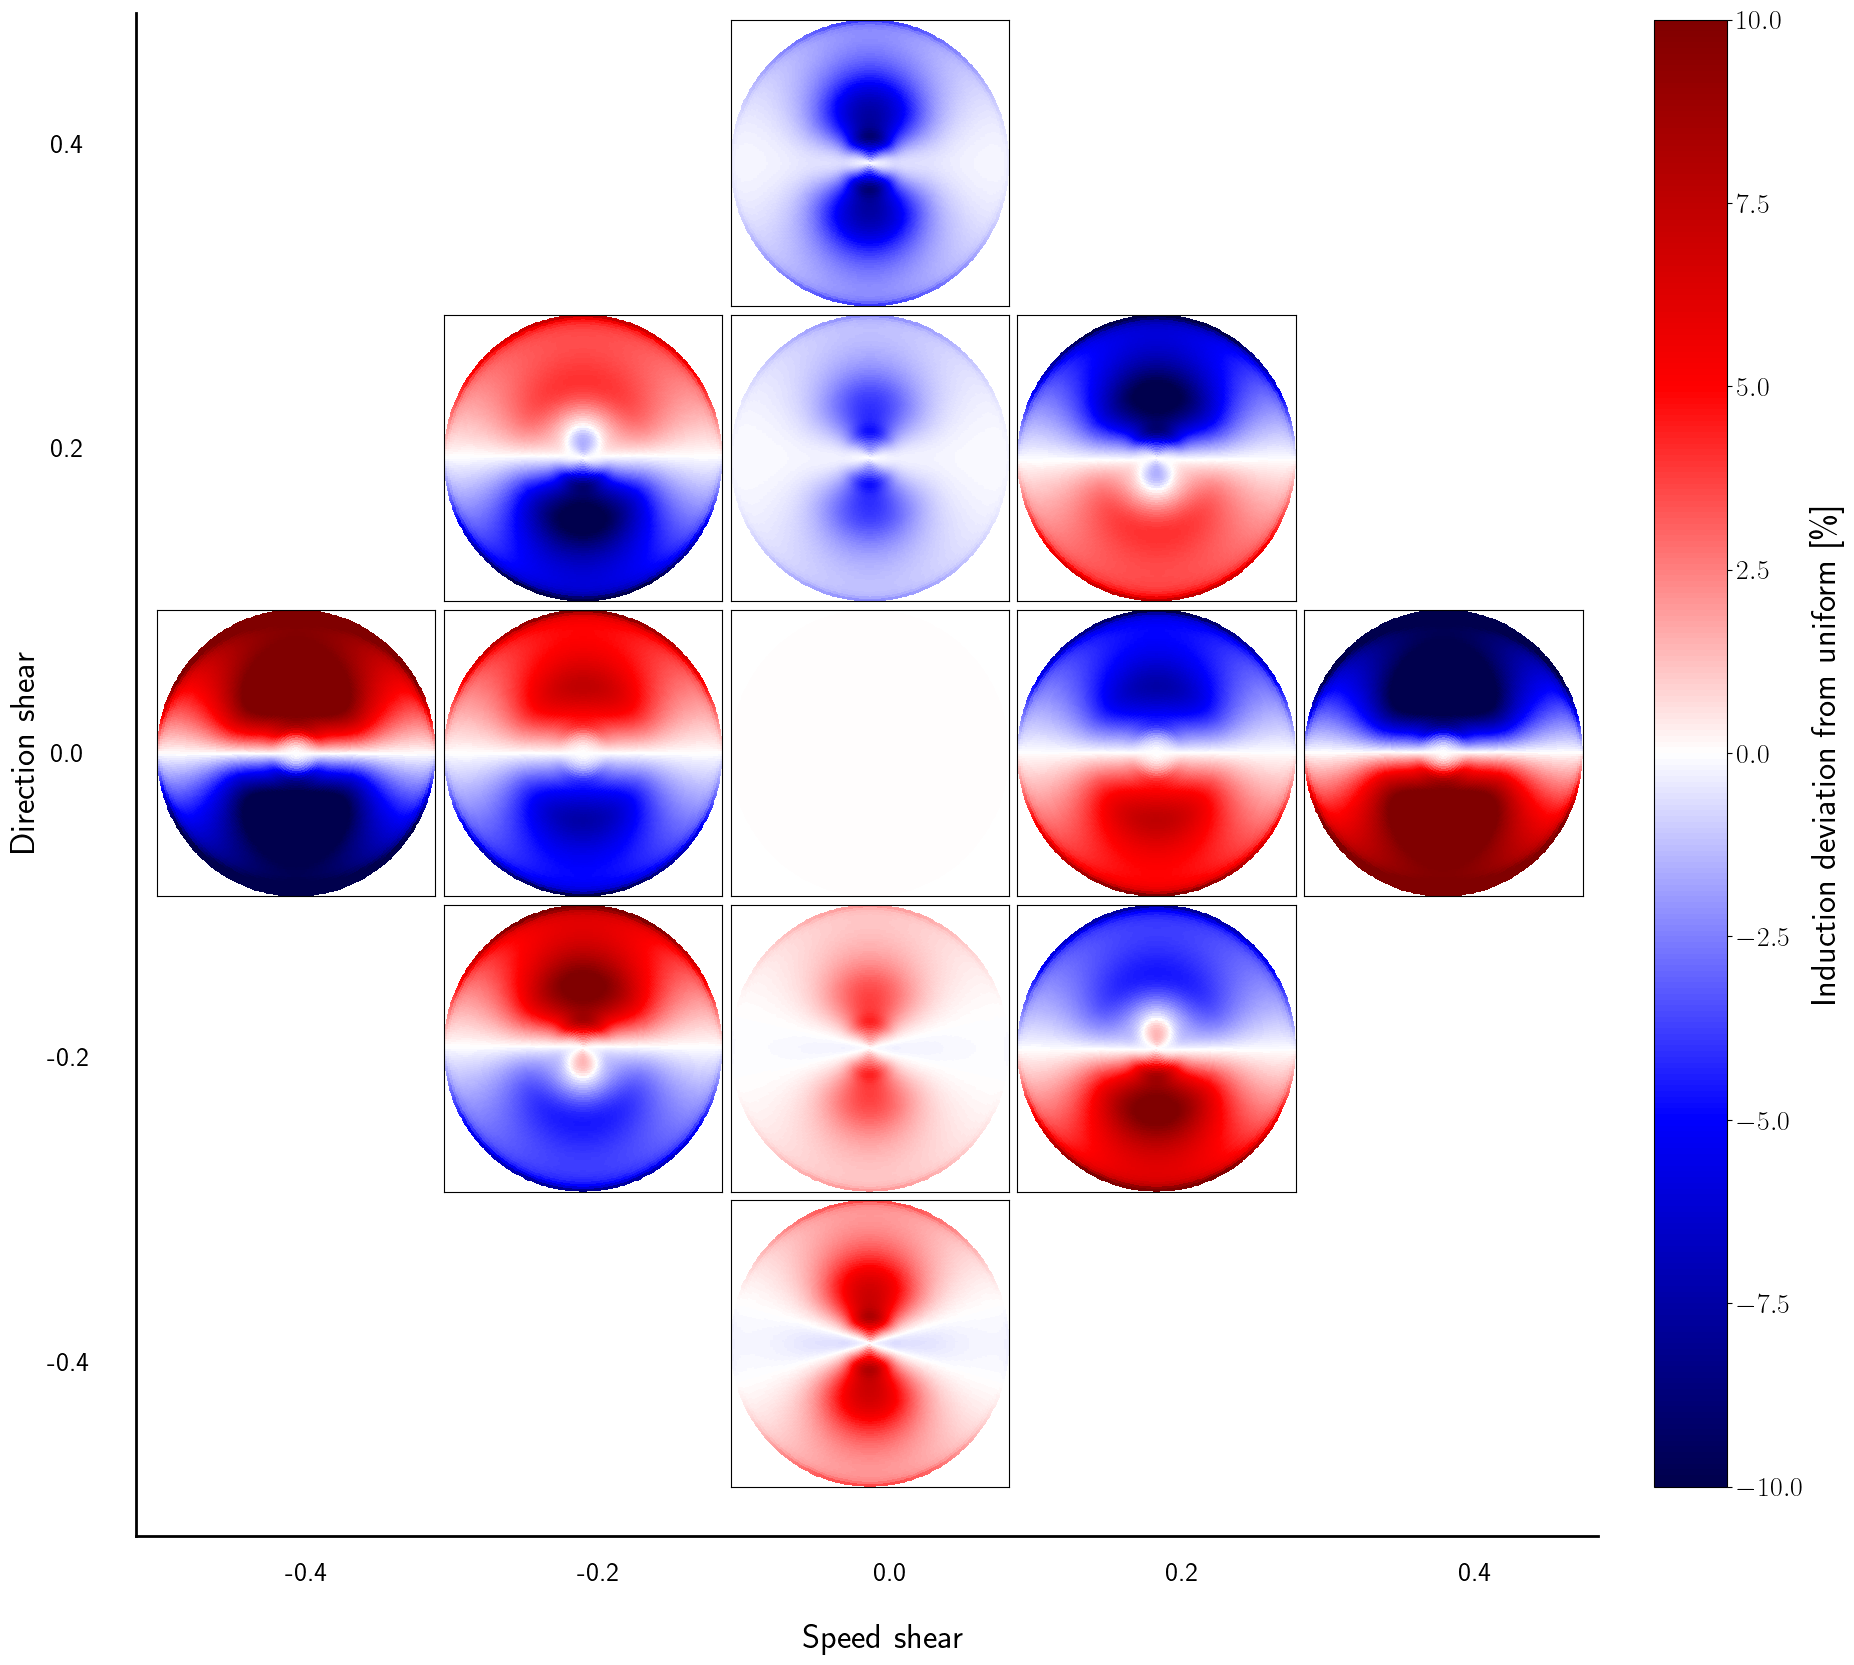

In [16]:

xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(17, 15), constrained_layout=True,sharex=True, sharey=True)
    
ref_case = solutions[ref].aoa('sector')

for i in range(len(xs)):
    current = solutions[i].aoa('sector')
    mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-10,vmax=10)
    ax[xs[i],ys[i]].invert_yaxis()
    ax[xs[i],ys[i]].set_xticklabels([])
    ax[xs[i],ys[i]].set_yticklabels([])
    ax[xs[i],ys[i]].set_xticks([])
    ax[xs[i],ys[i]].set_yticks([])

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
ax[4,4].axis('off')

# Add a single colorbar on the right-hand side
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('Induction deviation from uniform [\%]',fontsize=25)




# Add the number line below the subplots
line_y = -0.02  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.01, 0.85  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.1  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.43, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)


line_x = -0.01  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.02, 0.995  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.11  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.03,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.44, 'Direction shear', ha='center', fontsize=25,rotation=90)

plt.show()

/tmp/ipykernel_2353449/1506867727.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-10,vmax=10)
/tmp/ipykernel_2353449/1506867727.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-10,vmax=10)
/tmp/ipykernel_2353449/1506867727.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or

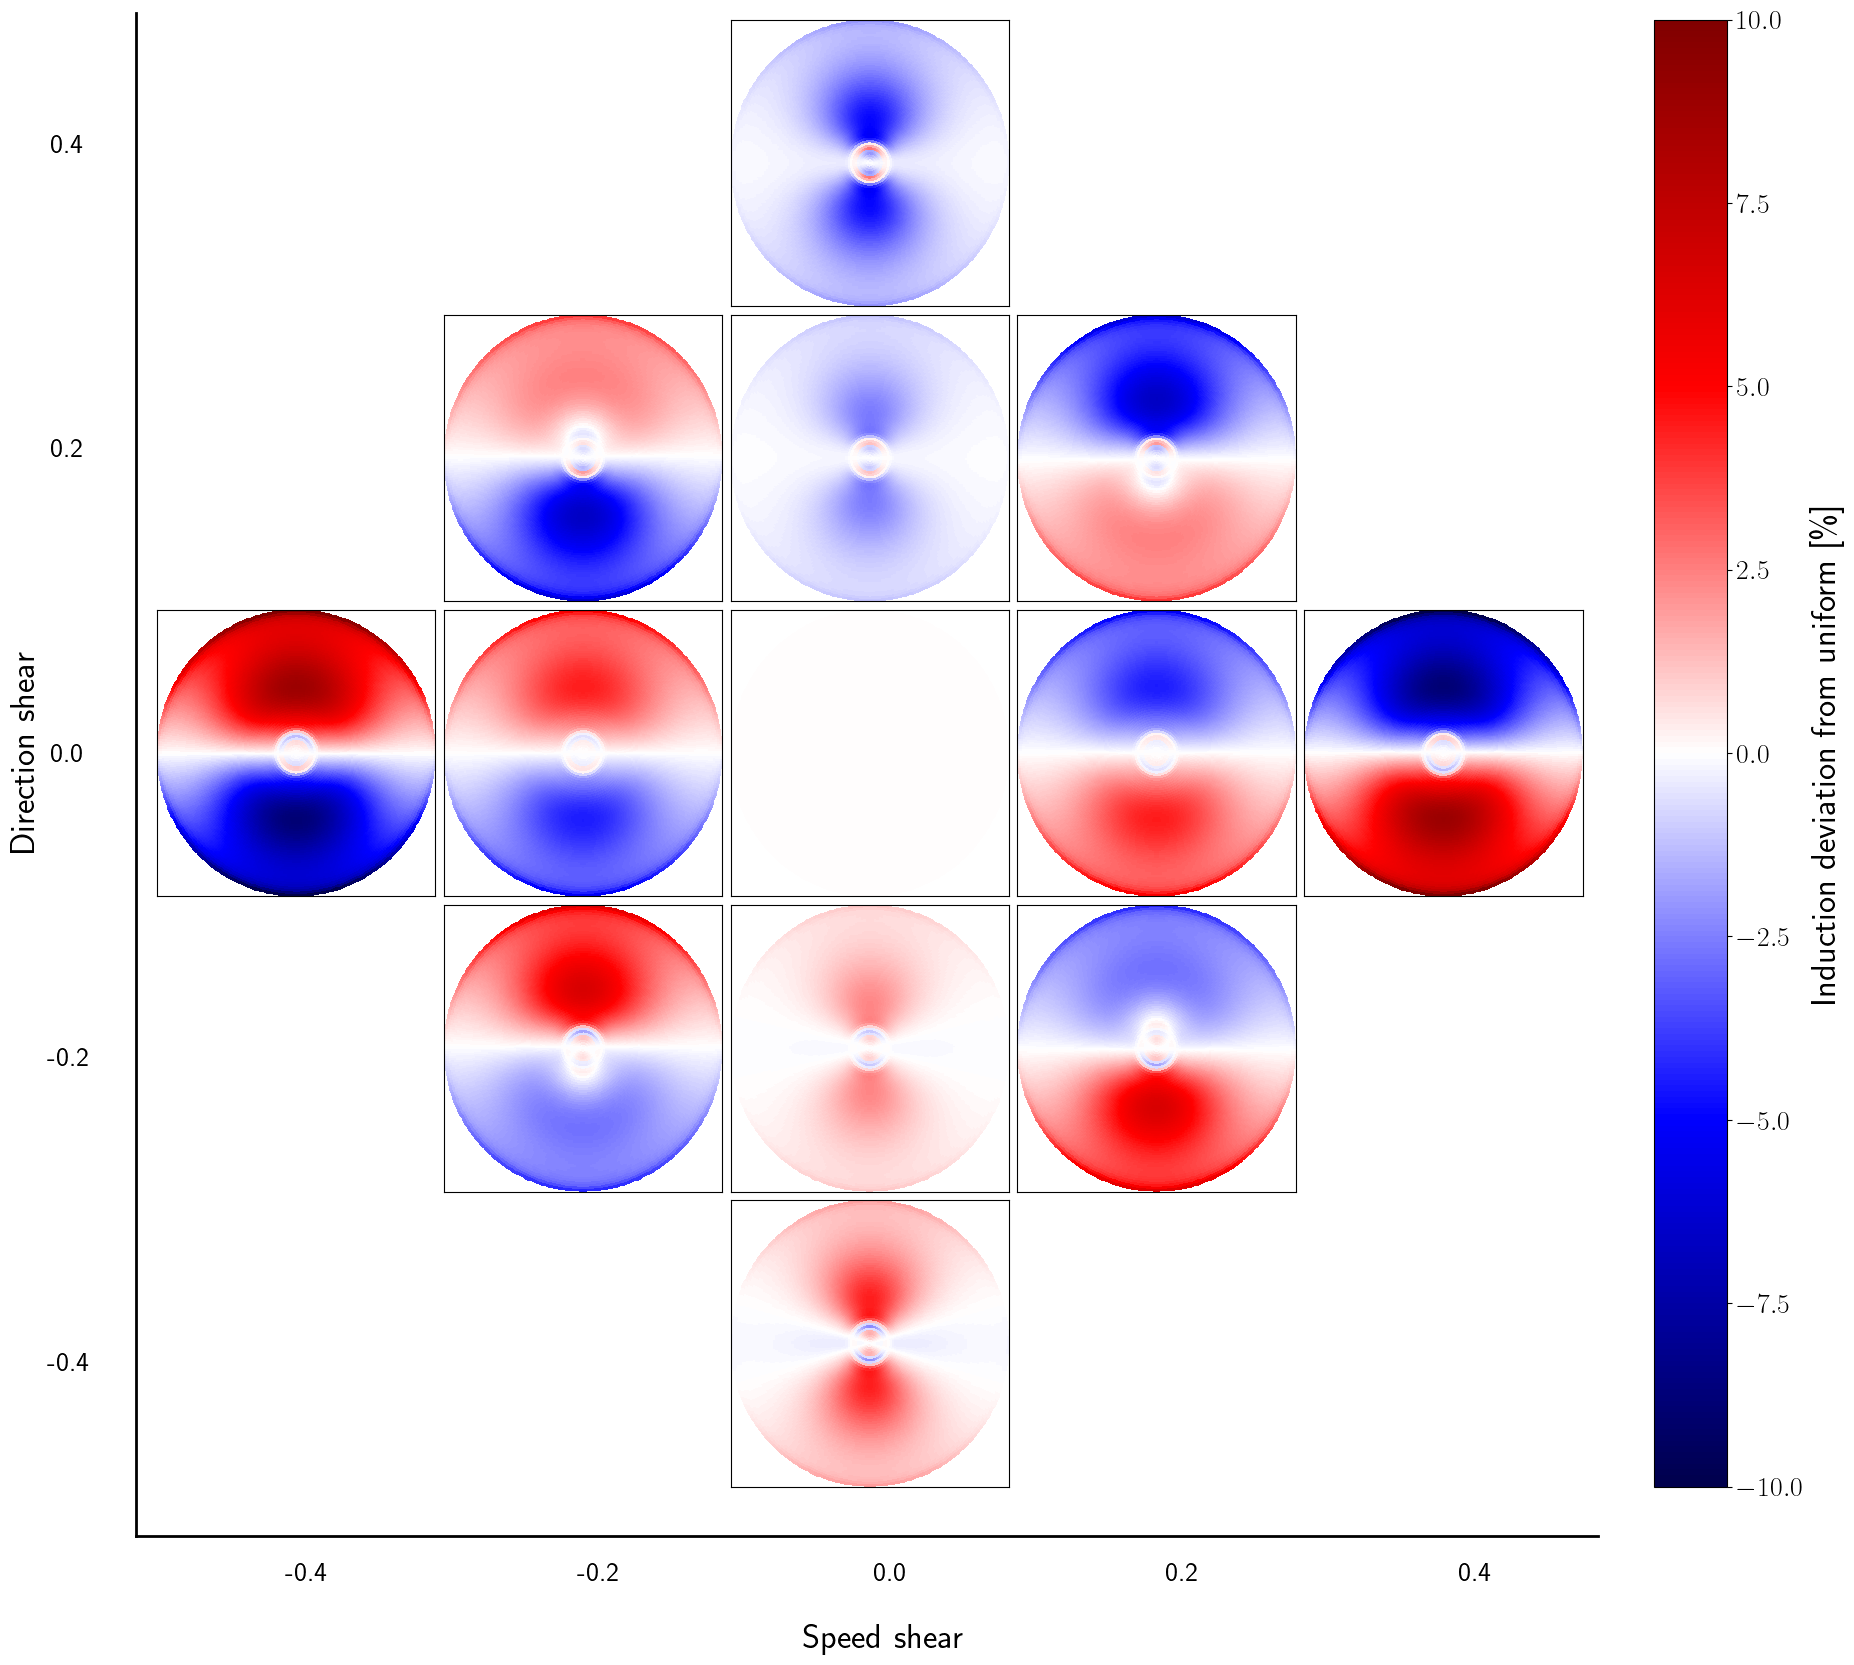

In [17]:

xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(17, 15), constrained_layout=True,sharex=True, sharey=True)
    
ref_case = solutions[ref].Cax('sector')

for i in range(len(xs)):
    current = solutions[i].Cax('sector')
    mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-10,vmax=10)
    ax[xs[i],ys[i]].invert_yaxis()
    ax[xs[i],ys[i]].set_xticklabels([])
    ax[xs[i],ys[i]].set_yticklabels([])
    ax[xs[i],ys[i]].set_xticks([])
    ax[xs[i],ys[i]].set_yticks([])

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
ax[4,4].axis('off')

# Add a single colorbar on the right-hand side
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('Induction deviation from uniform [\%]',fontsize=25)




# Add the number line below the subplots
line_y = -0.02  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.01, 0.85  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.1  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.43, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)


line_x = -0.01  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.02, 0.995  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.11  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.03,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.44, 'Direction shear', ha='center', fontsize=25,rotation=90)

plt.show()

/tmp/ipykernel_2353449/3700059465.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-30,vmax=30)
/tmp/ipykernel_2353449/3700059465.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-30,vmax=30)
/tmp/ipykernel_2353449/3700059465.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or

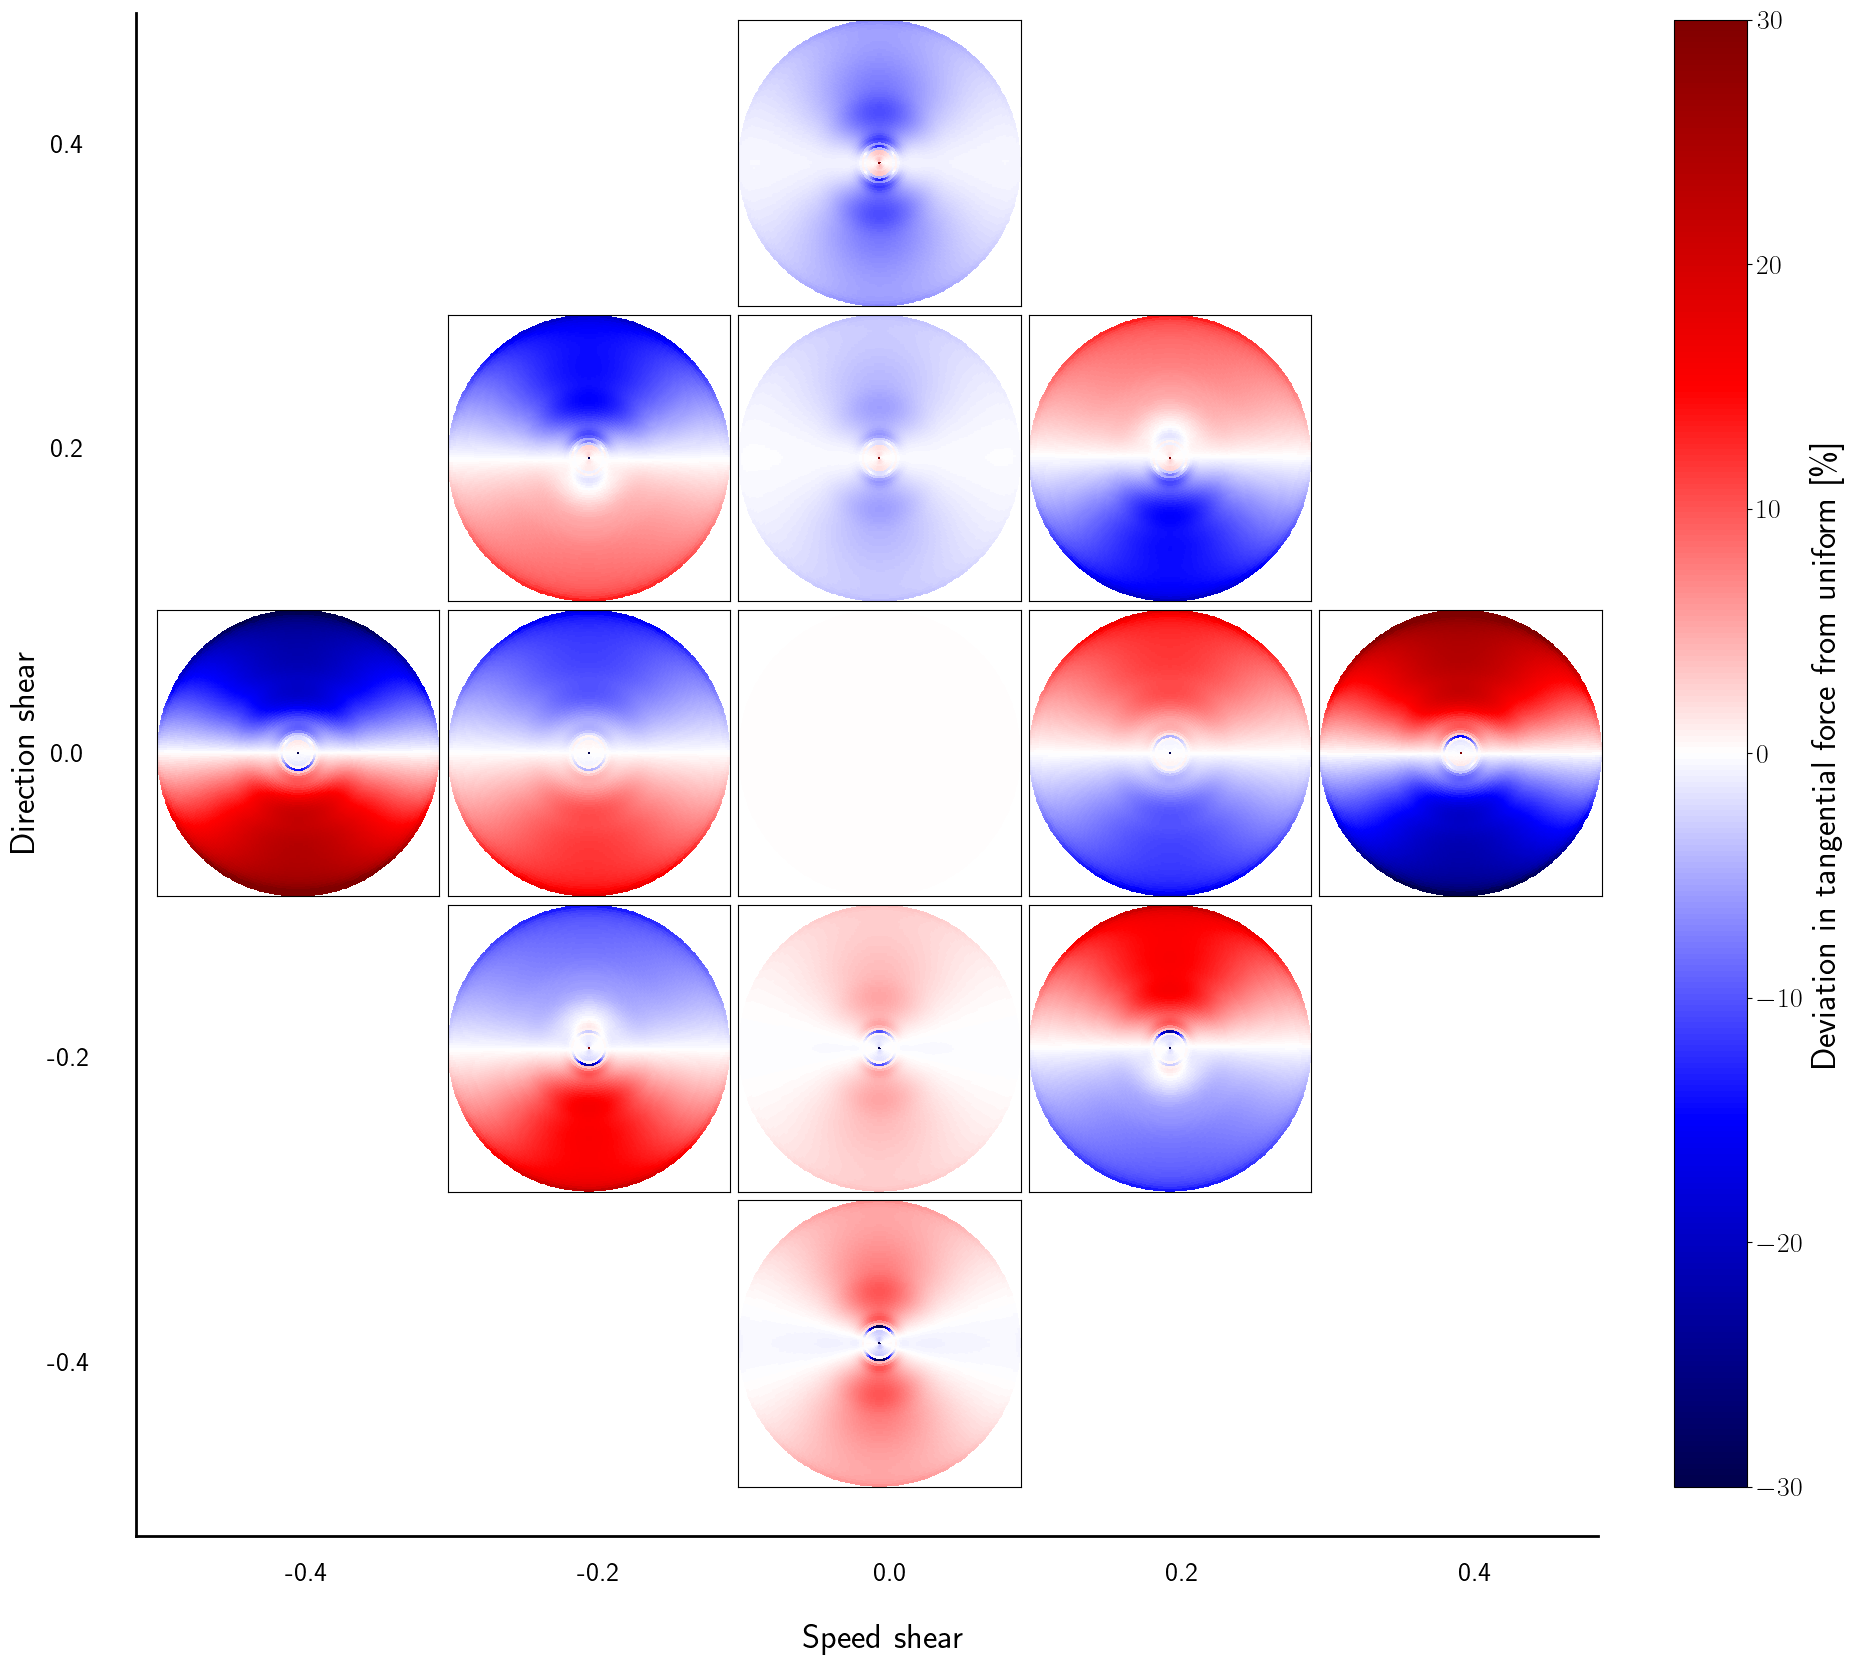

In [55]:

xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(17, 15), constrained_layout=True,sharex=True, sharey=True)
    
ref_case = solutions[ref].Ctan('sector')

for i in range(len(xs)):
    current = solutions[i].Ctan('sector')
    mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-30,vmax=30)
    # ax[xs[i],ys[i]].invert_yaxis()
    ax[xs[i],ys[i]].set_xticklabels([])
    ax[xs[i],ys[i]].set_yticklabels([])
    ax[xs[i],ys[i]].set_xticks([])
    ax[xs[i],ys[i]].set_yticks([])

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
ax[4,4].axis('off')

# Add a single colorbar on the right-hand side
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('Deviation in tangential force from uniform [\%]',fontsize=25)




# Add the number line below the subplots
line_y = -0.02  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.01, 0.85  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.1  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.43, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)


line_x = -0.01  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.02, 0.995  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.11  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.03,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.44, 'Direction shear', ha='center', fontsize=25,rotation=90)

plt.show()

/tmp/ipykernel_2353449/2004657443.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-30,vmax=30)
/tmp/ipykernel_2353449/2004657443.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-30,vmax=30)
/tmp/ipykernel_2353449/2004657443.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or

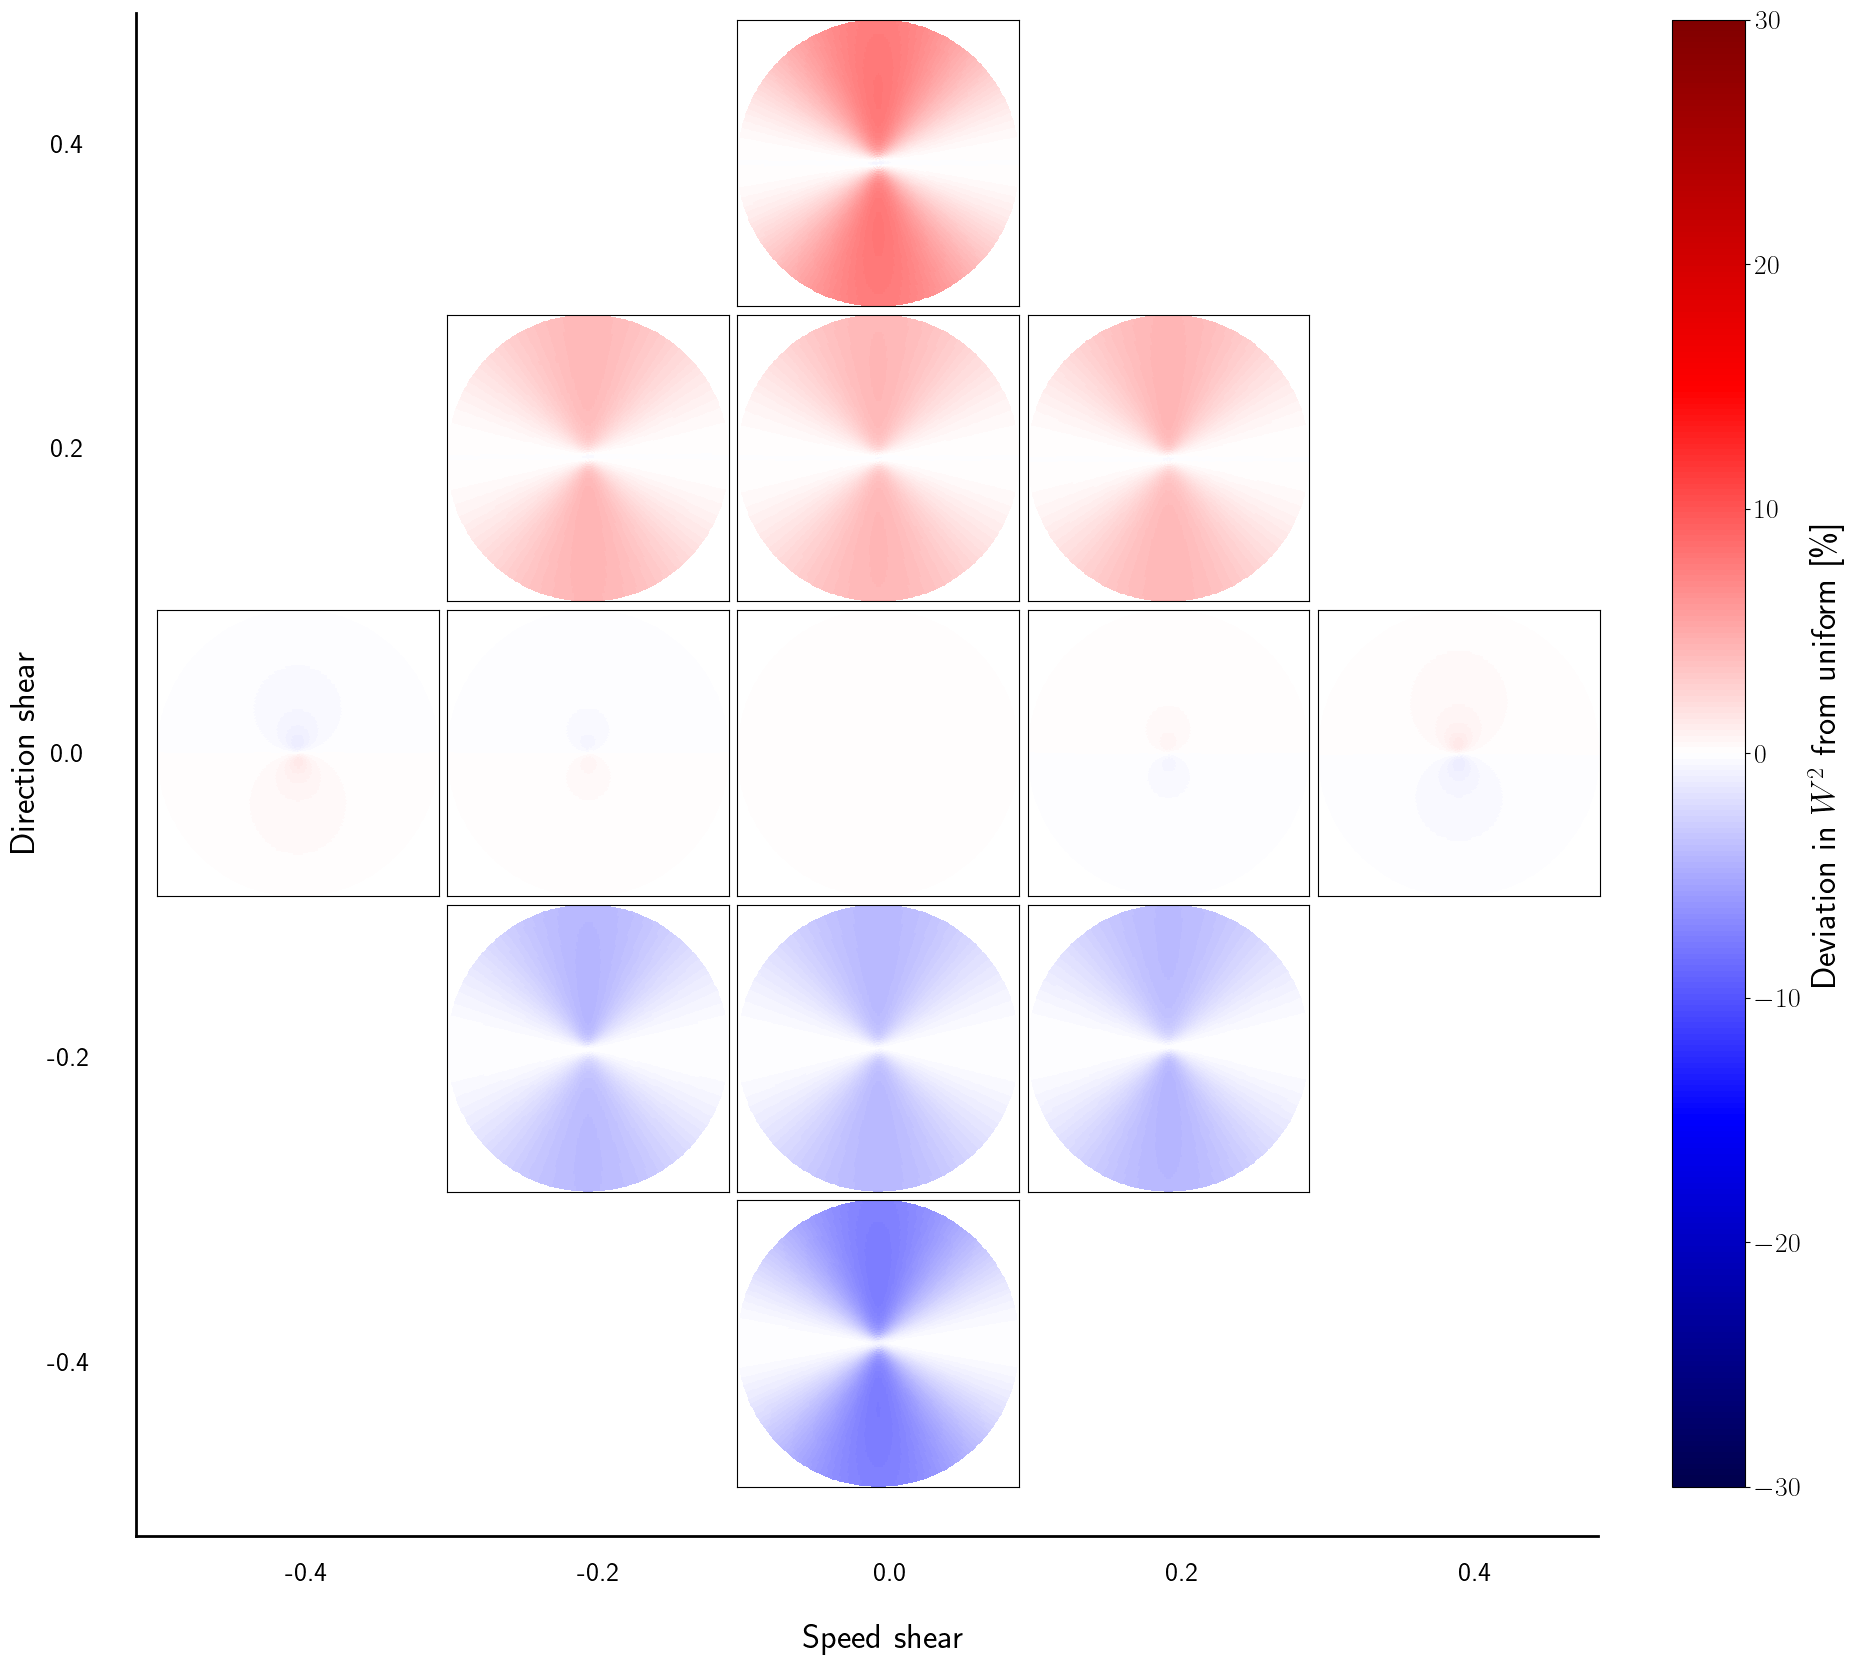

In [56]:

xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(17, 15), constrained_layout=True,sharex=True, sharey=True)
    
ref_case = solutions[ref].W('sector')**2

for i in range(len(xs)):
    current = solutions[i].W('sector')**2
    mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-30,vmax=30)
    # ax[xs[i],ys[i]].invert_yaxis()
    ax[xs[i],ys[i]].set_xticklabels([])
    ax[xs[i],ys[i]].set_yticklabels([])
    ax[xs[i],ys[i]].set_xticks([])
    ax[xs[i],ys[i]].set_yticks([])

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
ax[4,4].axis('off')

# Add a single colorbar on the right-hand side
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('Deviation in $W^2$ from uniform [\%]',fontsize=25)




# Add the number line below the subplots
line_y = -0.02  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.01, 0.85  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.1  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.43, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)


line_x = -0.01  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.02, 0.995  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.11  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.03,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.44, 'Direction shear', ha='center', fontsize=25,rotation=90)

plt.show()

/tmp/ipykernel_2353449/426229984.py:9: RuntimeWarning: invalid value encountered in divide
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-30,vmax=30)
/tmp/ipykernel_2353449/426229984.py:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-30,vmax=30)
/tmp/ipykernel_2353449/426229984.py:9: RuntimeWarning: invalid value encountered in divide
  mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-30,vmax=30)
/tmp/ipykernel_2353449/426229984.py:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonicall

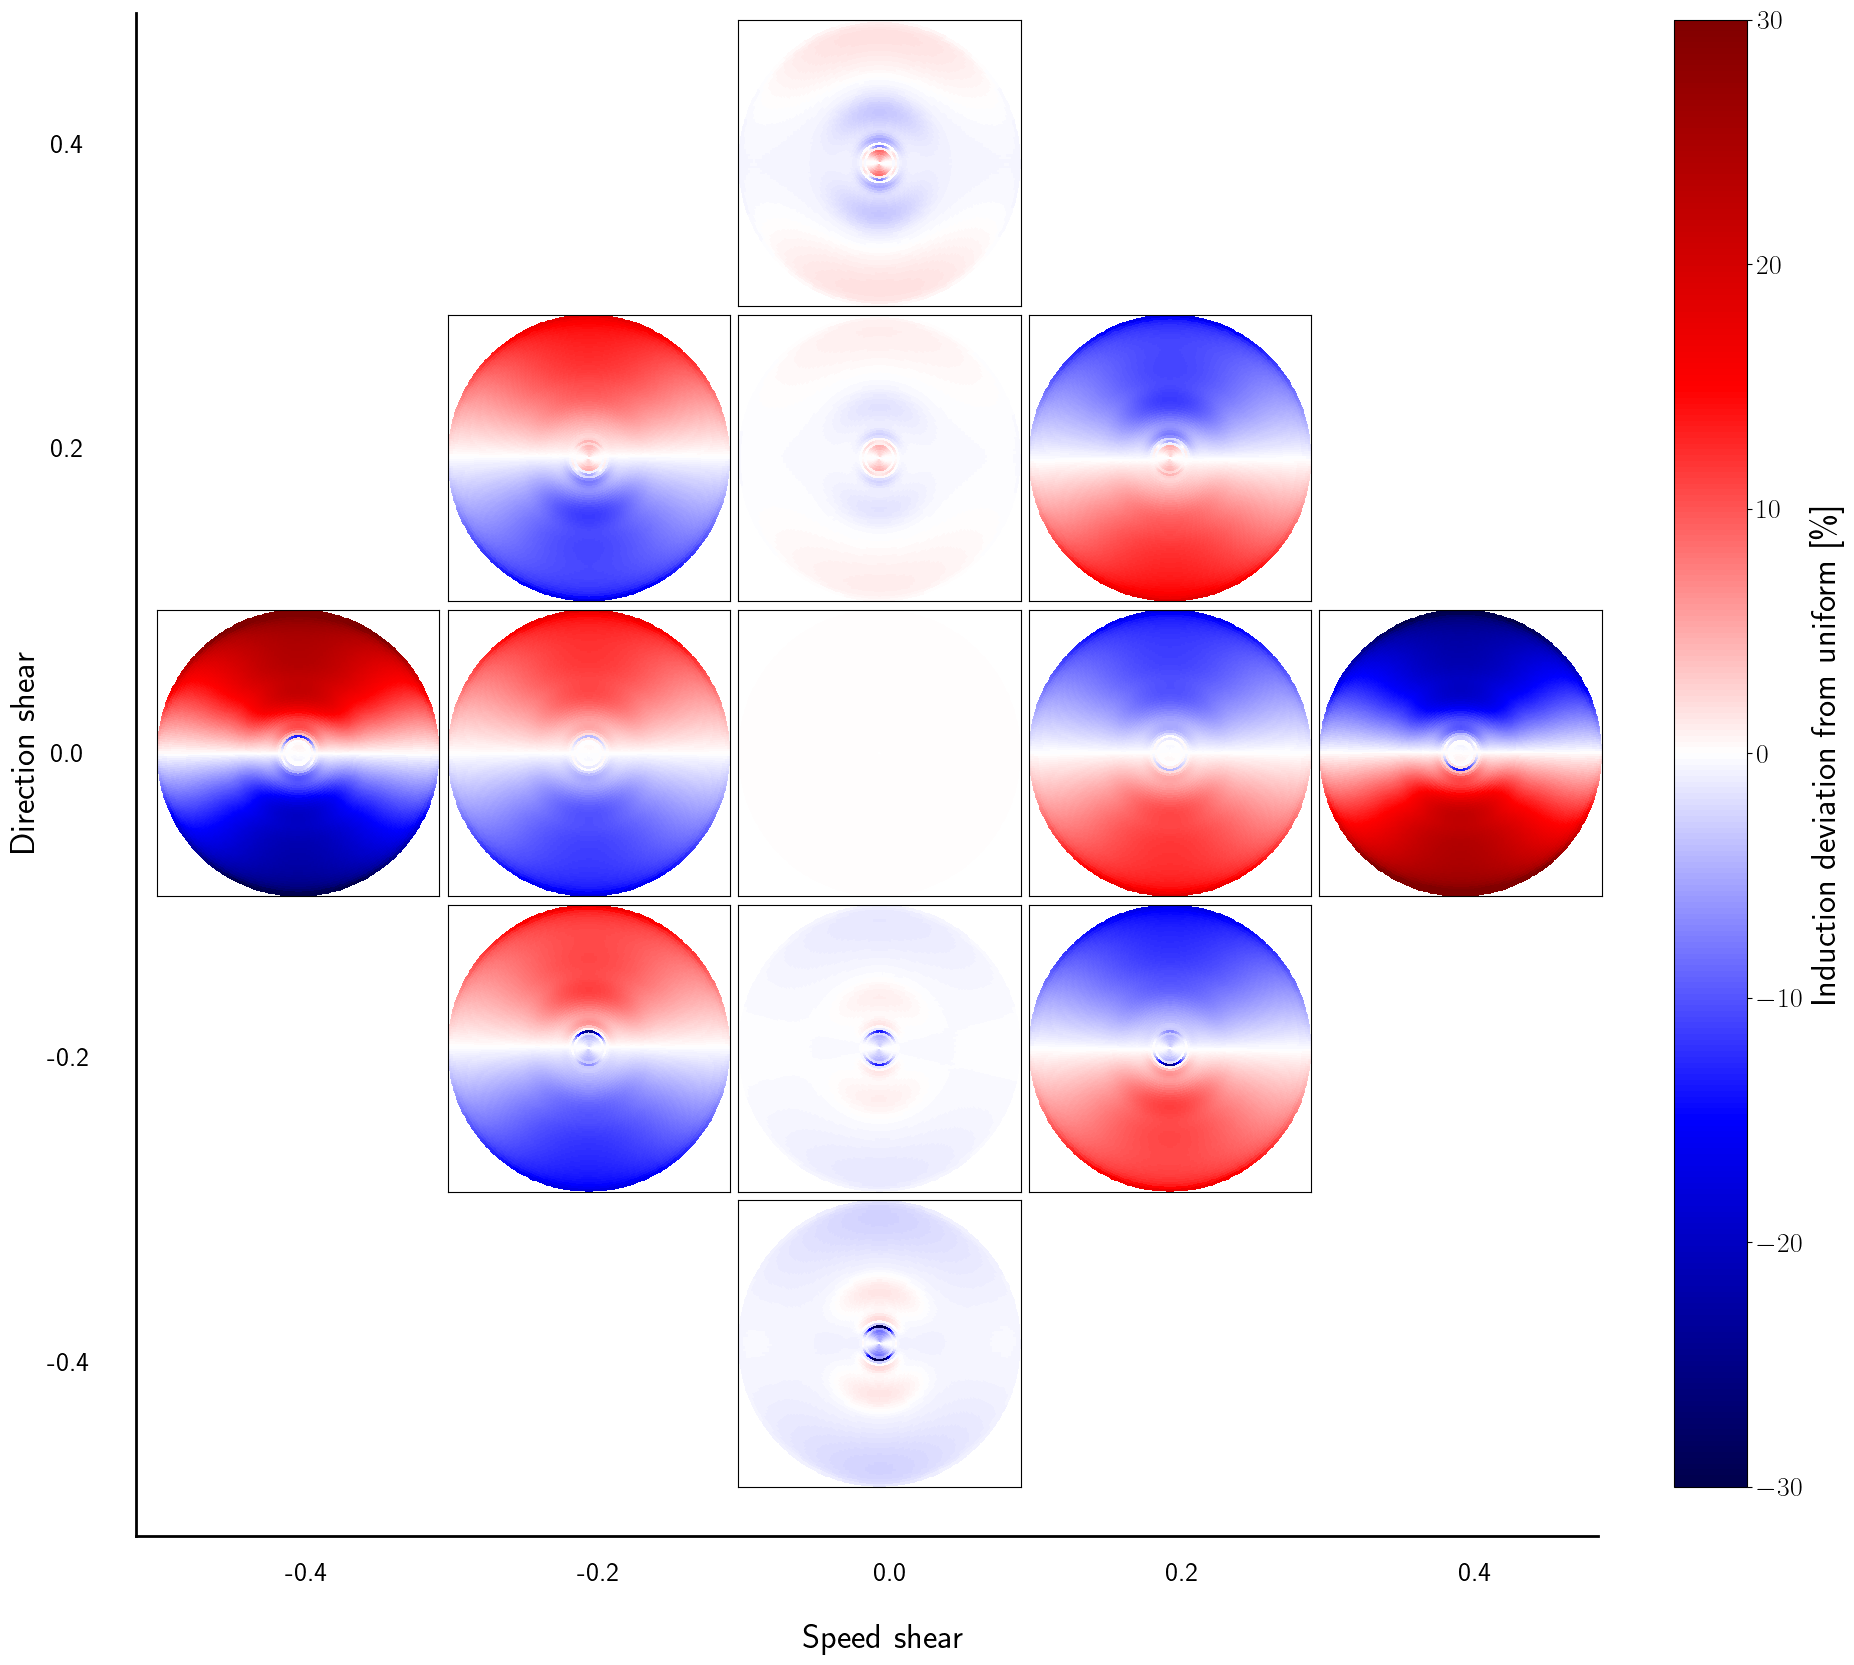

In [20]:

xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(17, 15), constrained_layout=True,sharex=True, sharey=True)
    
ref_case = ((solutions[ref].W('sector')**2 * solutions[ref].Ctan('sector')).T * solutions[ref].geom.mu * rotor.R).T
for i in range(len(xs)):
    current = ((solutions[i].W('sector')**2 * solutions[i].Ctan('sector')).T * solutions[i].geom.mu * rotor.R).T
    mesh = ax[xs[i],ys[i]].pcolormesh(cl_y_new, cl_x_new, ((current - ref_case)/ref_case * 100), cmap='seismic',vmin=-30,vmax=30)
    ax[xs[i],ys[i]].invert_yaxis()
    ax[xs[i],ys[i]].set_xticklabels([])
    ax[xs[i],ys[i]].set_yticklabels([])
    ax[xs[i],ys[i]].set_xticks([])
    ax[xs[i],ys[i]].set_yticks([])

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
ax[4,4].axis('off')

# Add a single colorbar on the right-hand side
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('Induction deviation from uniform [\%]',fontsize=25)




# Add the number line below the subplots
line_y = -0.02  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.01, 0.85  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.1  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.43, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)


line_x = -0.01  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.02, 0.995  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.11  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.03,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.44, 'Direction shear', ha='center', fontsize=25,rotation=90)

plt.show()